In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from sklearn import model_selection,preprocessing,metrics
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import re
from plotly import tools
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
pd.options.display.max_columns = 500

import ast 
import datetime as dt
import pickle
import gc 
gc.enable()

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 데이터 클렌징
- 대규모 데이터인점을 고려하여 데이터를 분할하여 로드한다.
- 샘플링을 통해 1차적인 EDA를 진행한다. 컬럼의 값에 변화가 없다면 성능에 영향을 주지 않으므로 삭제한다.


### 분할 로드 및 JSON 컬럼 파싱

In [ ]:
def parse(csv_path, nrows=None, chunksize=None,usecols=None):

    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()

    dfs = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     chunksize=chunksize,
                     nrows=nrows)
    for df in dfs:
      df.reset_index(drop = True,inplace=True)

      device_list=df['device'].tolist()
      
      #deleting unwanted columns before normalizing
      for device in device_list:
          del device['browserVersion'],device['browserSize'],device['flashVersion'],device['mobileInputSelector'],device['operatingSystemVersion'],device['screenResolution'],device['screenColors']
      df['device']=pd.Series(device_list)
      
      geoNetwork_list=df['geoNetwork'].tolist()
      for network in geoNetwork_list:
          del network['latitude'],network['longitude'],network['networkLocation'],network['cityId']
      df['geoNetwork']=pd.Series(geoNetwork_list)
      
      df['hits']=df['hits'].apply(ast.literal_eval)
      df['hits']=df['hits'].str[0]
      df['hits']=df['hits'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
      
      
      df['customDimensions']=df['customDimensions'].apply(ast.literal_eval)
      df['customDimensions']=df['customDimensions'].str[0]
      df['customDimensions']=df['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
      
      JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource','hits','customDimensions']

      for column in JSON_COLUMNS:
          column_as_df = json_normalize(df[column])
          column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
          df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

      if usecols:
          print('--- usecols')
          usecols = set(usecols).intersection(df.columns)
          usecols = list(usecols)
          use_df = df[usecols]
          del df
          gc.collect()
          ans = pd.concat([ans,use_df],axis = 0).reset_index(drop = True)
      else:
          print('--- no usecols')
          ans = pd.concat([ans,df],axis = 0).reset_index(drop = True)
          del df
          gc.collect()

      # print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
      print('Stored shape:', ans.shape)
    return ans

print("The 'parse' function to flatten JSON columns have been created")


The 'parse' function to flatten JSON columns have been created


In [ ]:
train_path = '/content/drive/MyDrive/data/train_v2.csv'
test_path = "/content/drive/MyDrive/data/test_v2.csv"

In [ ]:
data1 = parse('/content/drive/MyDrive/data/train_v2.csv', nrows=100000,chunksize=50000)
data2 = parse("/content/drive/MyDrive/data/test_v2.csv",nrows=100000,chunksize=50000)

print('data1 shape: ', data1.shape)
print('data2 shape: ', data2.shape)

data = data1.append(data2, sort=True)
del(data1, data2)

print('number of unique columns in data1 + data2:', data.shape)

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.



--- no usecols
Stored shape: (50000, 107)


<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.



--- no usecols
Stored shape: (100000, 118)


<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.



--- no usecols
Stored shape: (50000, 118)


<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.

<ipython-input-274-2a1dbf07d6a5>:40: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.



--- no usecols
Stored shape: (100000, 127)
data1 shape:  (100000, 118)
data2 shape:  (100000, 127)


<ipython-input-276-06d0730e3b48>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



number of unique columns in data1 + data2: (200000, 127)


In [ ]:
data

channelGrouping customDimensions_index customDimensions_value      date  \
0      Organic Search                      4                   EMEA  20171016   
1            Referral                      4          North America  20171016   
2              Direct                      4          North America  20171016   
3      Organic Search                      4                   EMEA  20171016   
4      Organic Search                      4        Central America  20171016   
...               ...                    ...                    ...       ...   
99995         Display                      4          North America  20180910   
99996  Organic Search                      4          North America  20180910   
99997          Direct                      4          North America  20180910   
99998  Organic Search                      4                   EMEA  20180910   
99999          Direct                      4          North America  20180910   

          device_browser device_deviceCategory  device_isMobile  \
0                Firefox               desktop            False   
1                 Chrome               desktop            False   
2                 Chrome                mobile             True   
3                 Chrome               desktop            False   
4                 Chrome               desktop            False   
...                  ...                   ...              ...   
99995             Chrome                mobile             True   
99996             Chrome               desktop            False   
99997             Safari                mobile             True   
99998  Internet Explorer               desktop            False   
99999             Chrome               desktop            False   

                     device_language    device_mobileDeviceBranding  \
0      not available in demo dataset  not available in demo dataset   
1      not available in demo dataset  not available in demo dataset   
2      not available in demo dataset  not available in demo dataset   
3      not available in demo dataset  not available in demo dataset   
4      not available in demo dataset  not available in demo dataset   
...                              ...                            ...   
99995  not available in demo dataset  not available in demo dataset   
99996  not available in demo dataset  not available in demo dataset   
99997  not available in demo dataset  not available in demo dataset   
99998  not available in demo dataset  not available in demo dataset   
99999  not available in demo dataset  not available in demo dataset   

             device_mobileDeviceInfo device_mobileDeviceMarketingName  \
0      not available in demo dataset    not available in demo dataset   
1      not available in demo dataset    not available in demo dataset   
2      not available in demo dataset    not available in demo dataset   
3      not available in demo dataset    not available in demo dataset   
4      not available in demo dataset    not available in demo dataset   
...                              ...                              ...   
99995  not available in demo dataset    not available in demo dataset   
99996  not available in demo dataset    not available in demo dataset   
99997  not available in demo dataset    not available in demo dataset   
99998  not available in demo dataset    not available in demo dataset   
99999  not available in demo dataset    not available in demo dataset   

            device_mobileDeviceModel device_operatingSystem  \
0      not available in demo dataset                Windows   
1      not available in demo dataset              Chrome OS   
2      not available in demo dataset                Android   
3      not available in demo dataset                Windows   
4      not available in demo dataset                Windows   
...                              ...                    ...   
99995  not available in demo dataset                Andro

### 샘플의 피처 탐색 및 선별

In [ ]:
d = data

jsonlist=[]
for i in range(len(d.columns)):   # for each column
    if (isinstance(d.iloc[1,i], list) ):  # see if some element 1 is a list
        jsonlist.append( d.columns[i] )   # if yes, then save name to list
print(jsonlist)

['hits_customDimensions', 'hits_customMetrics', 'hits_customVariables', 'hits_experiment', 'hits_product', 'hits_promotion', 'hits_publisher_infos']


In [ ]:
# 컬럼의 유니크값의 갯수와, 리스트형의 컬럼이 존재하는지 확인한다.
print("printout for each columns's unique values (incl. nans)\n")
for col in data.columns:
  try:
    print(col, ':', data[col].nunique(dropna=False))
  except TypeError:
    a=data[col].astype('str')
    print(col,':', a.nunique(dropna=False),'>>>>>>>>>> List')
del col

printout for each columns's unique values (incl. nans)

channelGrouping : 8
customDimensions_index : 2
customDimensions_value : 6
date : 81
device_browser : 46
device_deviceCategory : 3
device_isMobile : 2
device_language : 1
device_mobileDeviceBranding : 1
device_mobileDeviceInfo : 1
device_mobileDeviceMarketingName : 1
device_mobileDeviceModel : 1
device_operatingSystem : 20
fullVisitorId : 173472
geoNetwork_city : 433
geoNetwork_continent : 6
geoNetwork_country : 200
geoNetwork_metro : 71
geoNetwork_networkDomain : 11495
geoNetwork_region : 285
geoNetwork_subContinent : 23
hits_appInfo.exitScreenName : 865
hits_appInfo.landingScreenName : 770
hits_appInfo.screenDepth : 2
hits_appInfo.screenName : 770
hits_contentGroup.contentGroup1 : 5
hits_contentGroup.contentGroup2 : 11
hits_contentGroup.contentGroup3 : 4
hits_contentGroup.contentGroup4 : 2
hits_contentGroup.contentGroup5 : 2
hits_contentGroup.contentGroupUniqueViews1 : 2
hits_contentGroup.contentGroupUniqueViews2 : 2
hits_content

In [ ]:
# 변화가 없는 컬럼을 삭제한다.
print('Data shape before dropping constant columns:',data.shape)
print('\nColumns being dropped:')

for col in data.columns:
  try:
    if (data[col].nunique(dropna=False)==1):
      del(data[col])
      print(col)
  except TypeError:
    a=data[col].astype('str')
    if (a.nunique(dropna=False)==1):
      del(data[col])
      print(col)
del(col)
print('\ndata shape is now:',data.shape)

Data shape before dropping constant columns: (200000, 127)

Columns being dropped:
device_language
device_mobileDeviceBranding
device_mobileDeviceInfo
device_mobileDeviceMarketingName
device_mobileDeviceModel
hits_index
hits_value
socialEngagementType
totals_visits
trafficSource_adwordsClickInfo.criteriaParameters

data shape is now: (200000, 117)


In [ ]:
# JSON 객체가 복잡하지만, 의미없는 hit, impresssion을 내포하고 있기에 제거한다.
print('data shape:', data.shape)
data = data.drop(labels=['hits_promotion'], axis=1)
print('Removed hits_promotion')
print('data shape:', data.shape)

data shape: (200000, 117)
Removed hits_promotion
data shape: (200000, 116)


In [ ]:
# JSON 객체가 복잡하지만, 의미없는 hit, impresssion을 내포하고 있기에 제거한다.
print('data shape:', data.shape)
data = data.drop(labels=['hits_product'], axis=1)
print('Removed hits_product')
print('data shape:', data.shape)

data shape: (200000, 116)
Removed hits_product
data shape: (200000, 115)


In [ ]:
print("Printout for each column's number of unique values (incl. nans)\n")
for col in data.columns:
    try:
        print(col)
    except TypeError:
        a=data[col].astype('str')
        #print(a)
        print( col)
# Clean workspace
del(col)

Printout for each column's number of unique values (incl. nans)

channelGrouping
customDimensions_index
customDimensions_value
date
device_browser
device_deviceCategory
device_isMobile
device_operatingSystem
fullVisitorId
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
hits_appInfo.exitScreenName
hits_appInfo.landingScreenName
hits_appInfo.screenDepth
hits_appInfo.screenName
hits_contentGroup.contentGroup1
hits_contentGroup.contentGroup2
hits_contentGroup.contentGroup3
hits_contentGroup.contentGroup4
hits_contentGroup.contentGroup5
hits_contentGroup.contentGroupUniqueViews1
hits_contentGroup.contentGroupUniqueViews2
hits_contentGroup.contentGroupUniqueViews3
hits_contentGroup.previousContentGroup1
hits_contentGroup.previousContentGroup2
hits_contentGroup.previousContentGroup3
hits_contentGroup.previousContentGroup4
hits_contentGroup.previousContentGroup5
hits_customDimensions
hits_customMetrics


In [ ]:
final_vals = list(data.columns)

### 유의미한 피처 선별 결과

In [ ]:
json_vars = ['device', 'geoNetwork', 'totals', 'trafficSource', 'hits', 'customDimensions']

final_vars = ['channelGrouping','customDimensions_index','customDimensions_value','date',
'device_browser','device_deviceCategory','device_isMobile','device_operatingSystem',
'fullVisitorId','geoNetwork_city','geoNetwork_continent','geoNetwork_country',
'geoNetwork_metro','geoNetwork_networkDomain','geoNetwork_region','geoNetwork_subContinent',
'hits_appInfo.exitScreenName','hits_appInfo.landingScreenName','hits_appInfo.screenDepth',
'hits_appInfo.screenName','hits_contentGroup.contentGroup1','hits_contentGroup.contentGroup2',
'hits_contentGroup.contentGroup3','hits_contentGroup.contentGroup4','hits_contentGroup.contentGroup5',
'hits_contentGroup.contentGroupUniqueViews1','hits_contentGroup.contentGroupUniqueViews2',
'hits_contentGroup.contentGroupUniqueViews3','hits_contentGroup.previousContentGroup1',
'hits_contentGroup.previousContentGroup2','hits_contentGroup.previousContentGroup3',
'hits_contentGroup.previousContentGroup4','hits_contentGroup.previousContentGroup5',
'hits_customDimensions','hits_customMetrics','hits_customVariables','hits_dataSource',
'hits_eCommerceAction.action_type','hits_eCommerceAction.option','hits_eCommerceAction.step',
'hits_eventInfo.eventAction','hits_eventInfo.eventCategory','hits_eventInfo.eventLabel',
'hits_exceptionInfo.isFatal','hits_experiment','hits_hitNumber','hits_hour','hits_isEntrance',
'hits_isExit','hits_isInteraction','hits_item.currencyCode','hits_item.transactionId',
'hits_latencyTracking.domContentLoadedTime','hits_latencyTracking.domInteractiveTime',
'hits_latencyTracking.domLatencyMetricsSample','hits_latencyTracking.domainLookupTime',
'hits_latencyTracking.pageDownloadTime','hits_latencyTracking.pageLoadSample',
'hits_latencyTracking.pageLoadTime','hits_latencyTracking.redirectionTime',
'hits_latencyTracking.serverConnectionTime','hits_latencyTracking.serverResponseTime',
'hits_latencyTracking.speedMetricsSample','hits_minute','hits_page.hostname','hits_page.pagePath',
'hits_page.pagePathLevel1','hits_page.pagePathLevel2','hits_page.pagePathLevel3',
'hits_page.pagePathLevel4','hits_page.pageTitle','hits_page.searchCategory','hits_page.searchKeyword',
'hits_promotionActionInfo.promoIsClick','hits_promotionActionInfo.promoIsView','hits_publisher_infos',
'hits_referer','hits_social.hasSocialSourceReferral','hits_social.socialInteractionNetworkAction',
'hits_social.socialNetwork','hits_time','hits_transaction.affiliation','hits_transaction.currencyCode',
'hits_transaction.localTransactionRevenue','hits_transaction.localTransactionShipping',
'hits_transaction.localTransactionTax','hits_transaction.transactionId',
'hits_transaction.transactionRevenue','hits_transaction.transactionShipping',
'hits_transaction.transactionTax','hits_type','totals_bounces','totals_hits','totals_newVisits',
'totals_pageviews','totals_sessionQualityDim','totals_timeOnSite','totals_totalTransactionRevenue',
'totals_transactionRevenue','totals_transactions','trafficSource_adContent',
'trafficSource_adwordsClickInfo.adNetworkType','trafficSource_adwordsClickInfo.gclId',
'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_adwordsClickInfo.page',
'trafficSource_adwordsClickInfo.slot','trafficSource_campaign','trafficSource_isTrueDirect',
'trafficSource_keyword','trafficSource_medium','trafficSource_referralPath','trafficSource_source',
'visitId','visitNumber','visitStartTime']

In [ ]:
data = parse(train_path, nrows=500000, chunksize=100000,usecols=final_vals)
data.to_pickle('/content/drive/MyDrive/data/5m.pkl')

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/data/5m.pkl')

## EDA
- 1차적으로 걸러낸 피처들을 시각화하여 심화 EDA를 진행한다.
- 백 수십개의 피처가 존재하기 때문에 주요한 피처를 선별하는 작업이 필수적인 상황.
- 도메인지식과 분포를 통해 유의미한 컬럼을 선별한다


In [ ]:
# 컴피티션 데이터는 전처리된 라벨값을 제공한다. (매출($) * 10^6)
data['totals_transactionRevenue'].fillna(0,inplace=True)
data['totals_transactionRevenue'] = data['totals_transactionRevenue'].astype('float')/1000000


In [ ]:
#재구매 결측치 0값으로 변경
data.totals_newVisits.fillna('0',inplace=True)
#모바일 유무 1,0으로 변경
data.device_isMobile.replace(True,'1',inplace=True)
data.device_isMobile.replace(False,'0',inplace=True)

#### EDA를 위한 시각화 함수 정의
피처의 분포가 모델의 성능에 유의미한지 확인하며 데이터를 EDA한다.\
아래의 시각화 함수는 아래의 4가지 중요 요소를 보여준다.

1. 피처에서 발생한 인터랙션의 수
2. 피처에서 발생한 결제의 수
3. 피처에서 발생한 결제의 규모
4. 피처에서 발생한 결제의 평균

In [ ]:
def bar_plot_stats(plot_list,data,y_count=50,figsize_x=20,figsize_y=10,sorting='count'):
  df = data.copy()
  for i in range(len(plot_list)):
    cnt_srs = df.groupby(plot_list[i])['totals_transactionRevenue'].agg(['size',lambda x: np.count_nonzero(x),'sum','mean'])
    cnt_srs.columns = ['count','count of non-zero revenue','sum','mean']
    cnt_srs = cnt_srs.sort_values(by=sorting,ascending=False)
    cnt_srs = cnt_srs.head(y_count).reset_index()

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(figsize_x, figsize_y),sharey=True)

    sns.barplot(x=cnt_srs['count'], y=cnt_srs[plot_list[i]], color='mediumaquamarine', ax=ax[0])
    ax[0].set(xlabel='Count', ylabel=str(plot_list[i]), title=f'Top {y_count} by Count')

    sns.barplot(x=cnt_srs['count of non-zero revenue'], y=cnt_srs[plot_list[i]], color='c', ax=ax[1])
    ax[1].set(xlabel='count of non-zero revenue', ylabel=str(plot_list[i]), title=f'Top {y_count} By Count of Non-Zero Rev')

    sns.barplot(x=cnt_srs['sum'], y=cnt_srs[plot_list[i]], color='darkcyan', ax=ax[2])
    ax[2].set(xlabel='sum', ylabel=str(plot_list[i]), title=f'Top {y_count} By Rev(Sum)')

    sns.barplot(x=cnt_srs['mean'], y=cnt_srs[plot_list[i]], color='darkslategrey', ax=ax[3])
    ax[3].set(xlabel='mean', ylabel=str(plot_list[i]), title=f'Top {y_count} By Rev(Mean)')


In [ ]:
def kde_scatter(cols, data, figsize_x=10,figsize_y=7):

    cnt_srs = data.groupby(cols)['totals_transactionRevenue'].agg(['size',lambda x: np.count_nonzero(x),'sum','mean'])
    cnt_srs.columns = ['count','count of non-zero revenue','sum','mean']
    cnt_srs.reset_index(inplace=True)
        
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(figsize_x, figsize_y),sharex=True)

    sns.kdeplot(data[cols].astype('float64'), color="#006633", fill=True, alpha=0.3,ax=ax[0])
    ax[0].set(xlabel=cols, ylabel='Dense',title=f'Distribution of records Total')

    sns.kdeplot(data[data['totals_transactionRevenue'] > 0][cols].astype('float64'),
                label='rev', color="#ff6600", fill=True, alpha=0.1, ax=ax[1])
    ax[1].set(xlabel=cols, ylabel='Dense',title=f'Distribution of records Non Zero Revenue')

    sns.scatterplot(x=cnt_srs[cols].astype('float64'),y=cnt_srs['sum'],
                label='sum', color="lightcoral",  ax=ax[2])
    ax[2].set(xlabel=cols, ylabel='Rev',title=f'Distribution of Revenue Sum')

    sns.scatterplot(x=cnt_srs[cols].astype('float64'),y=cnt_srs['mean'],
                label='mean', color="tan",  ax=ax[3])
    ax[3].set(xlabel=cols, ylabel='Rev',title=f'Distribution of Revenue mean')



In [ ]:
# 피처 확인 절차를 위한 함수 정의
def resumetable(data):
    print(f'데이터 세트 형상: {data.shape}')
    summary = pd.DataFrame(data.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = data.isnull().sum().values
    summary['결측값 비율'] = data.isnull().sum().values /  len(data) *100
    summary['첫 번째 값'] = data.loc[0].values
    summary['두 번째 값'] = data.loc[1].values
    summary['세 번째 값'] = data.loc[2].values
    
    return summary


#### 파생변수 생성 함수 (날짜 기반 )
재방문자의 구매율이 높은 점, 방문시간이 길어짐에 따라 구매율이 높아지는 점에 착안하여 아래의 파생변수 생성
- 월별 평균 방문 횟수
- 주별 방문 횟수
- 주간 방문 횟수
- 생애 총 방문 수
- stickness
- 첫번째 재방문 까지 걸린 시간

In [ ]:
#재방문 횟수 data test

# groupby() 함수를 사용해서 그룹핑한 뒤 집계 함수 적용하기
def get_date_feature(data):
  month_visit_count = data.groupby(['fullVisitorId'])['month'].agg('count').reset_index()
  week_visit_count = data.groupby(['fullVisitorId'])['week'].agg('count').reset_index()
  weekdaily_visit_count = data.groupby(['fullVisitorId','year','week'])['weekday'].agg('count').reset_index()
  weekdaily_visit_count = weekdaily_visit_count.groupby(['fullVisitorId'])['weekday'].agg('mean').reset_index()

  month_visit_count.rename(columns={'month':'monthly_visit'},inplace=True)
  week_visit_count.rename(columns={'week':'weekly_visit'},inplace=True)
  weekdaily_visit_count.rename(columns={'weekday':'weekdaily_visit'},inplace=True)

  data = data.merge(month_visit_count,on='fullVisitorId',how='left')
  data = data.merge(week_visit_count,on='fullVisitorId',how='left')
  data = data.merge(weekdaily_visit_count,on='fullVisitorId',how='left')
  return data

# data = get_date_feature(data)

In [ ]:
#data test
def get_retention_rate(data):
  total_visit_date = data.groupby(['fullVisitorId','date'])['weekday'].agg('count').reset_index()
  first_visit_date = total_visit_date.groupby('fullVisitorId')['date'].min().reset_index()
  total_visit_date.drop('weekday',axis=1,inplace=True)

  total_visit_date_2 = pd.concat([total_visit_date, first_visit_date]).drop_duplicates(keep=False)

  second_visit_date = total_visit_date_2.groupby('fullVisitorId')['date'].min().reset_index()
  last_visit_date = total_visit_date_2.groupby('fullVisitorId')['date'].max().reset_index()

  first_visit_date.rename(columns={'date':'date_first_visit'},inplace=True)
  second_visit_date.rename(columns={'date':'date_second_visit'},inplace=True)
  last_visit_date.rename(columns={'date':'date_last_visit'},inplace=True)

  visit_date_merged = first_visit_date.merge(second_visit_date,on='fullVisitorId',how='left')
  visit_date_merged = visit_date_merged.merge(last_visit_date,on='fullVisitorId',how='left')

  visit_date_merged['revisit_dur_time'] = (visit_date_merged['date_second_visit'] - visit_date_merged['date_first_visit']).dt.days
  visit_date_merged['total_life_time'] = (visit_date_merged['date_last_visit'] - visit_date_merged['date_first_visit']).dt.days

  #stickness
  agg_total_visit_count = total_visit_date.groupby('fullVisitorId')['date'].agg('count').reset_index()
  agg_total_visit_count.rename(columns={'date':'agg_total_visit_count'},inplace=True)
  agg_total_visit_count['agg_total_visit_count'] = agg_total_visit_count['agg_total_visit_count'] - 1
  agg_total_visit_count.value_counts()
  visit_date_merged = visit_date_merged.merge(agg_total_visit_count,on='fullVisitorId',how='left')
  visit_date_merged['stickness'] = visit_date_merged['agg_total_visit_count']/visit_date_merged['total_life_time']

  #drop datetype
  visit_date_merged.drop(['date_first_visit','date_second_visit','date_last_visit'],axis=1,inplace=True)

  #merge to train df
  data = data.merge(visit_date_merged,on='fullVisitorId',how='left')

  ##memory clear
  del total_visit_date
  del total_visit_date_2
  gc.collect()
  return data

# data = get_retention_rate(data)

#### 파생변수 생성 함수 (상품 기반 )
- 상품 조회를 관심도로 정의하고 엔트로피화 하여 피처로 활용

In [ ]:
#엔트로피 피쳐 함수 정의
def get_entropy(data,numerator,denumerator):
  data[numerator].value_counts()
  entropy_df = data[['fullVisitorId',denumerator,numerator]]\
  .groupby(['fullVisitorId'])\
  .agg({numerator:'count',denumerator:'sum'}).reset_index()

  entropy_df[denumerator].value_counts(dropna=False)
  entropy_df[denumerator] = entropy_df[denumerator].astype('float')

  entropy_df['Div'] = entropy_df[numerator]/entropy_df[denumerator]
  with np.errstate(divide='ignore'):
      entropy_df['Ent_Upc'] = np.where(entropy_df['Div']==0, 0, entropy_df['Div'] * np.log2(entropy_df['Div']) * -1)
  
  entropy_df = entropy_df[['fullVisitorId','Ent_Upc']]
  entropy_df['Ent_Upc'] = np.abs(entropy_df['Ent_Upc'])
  entropy_df.rename(columns={'Ent_Upc':f'{numerator}_Ent'},inplace=True)

  return entropy_df
  


In [ ]:
content_2_ent = get_entropy(data,'hits_contentGroup.contentGroup2','totals_hits')
trafficAdwordsClickInfo_ent = get_entropy(data,'trafficSource_adwordsClickInfo.gclId','totals_hits')

data = data.merge(content_2_ent,on='fullVisitorId',how='left')
data = data.merge(trafficAdwordsClickInfo_ent,on='fullVisitorId',how='left')


### 파생변수 EDA

#### stickness
총 생애기간동안 얼마나 자주 들어왔는가를 측정하는 피처
- 아웃라이어를 명확히 구분하는 점 확인

In [ ]:
cols = 'stickness'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### agg_total_visit_count
총 방문 횟수 측정 피처
- 매출규모의 편차가 심한 불균형한 데이터이지만, 대부분의 구매자는 5회 방문 내로 구매함.
- 이후, 아웃라이어는 각자의 경향을 가지고 있음

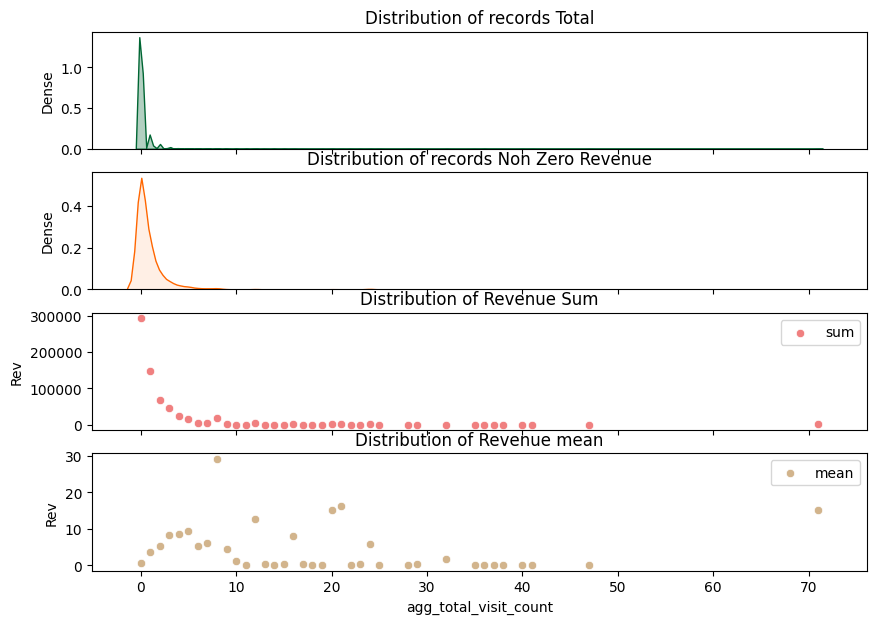

In [ ]:
cols = 'agg_total_visit_count'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### total_life_time
- 첫 방문과 마지막 방문 기간 사이를 총 생애 주기로 정의
- 매출 아웃라이어의 경우, 총 생애주기가 김을 확인할 수 있다

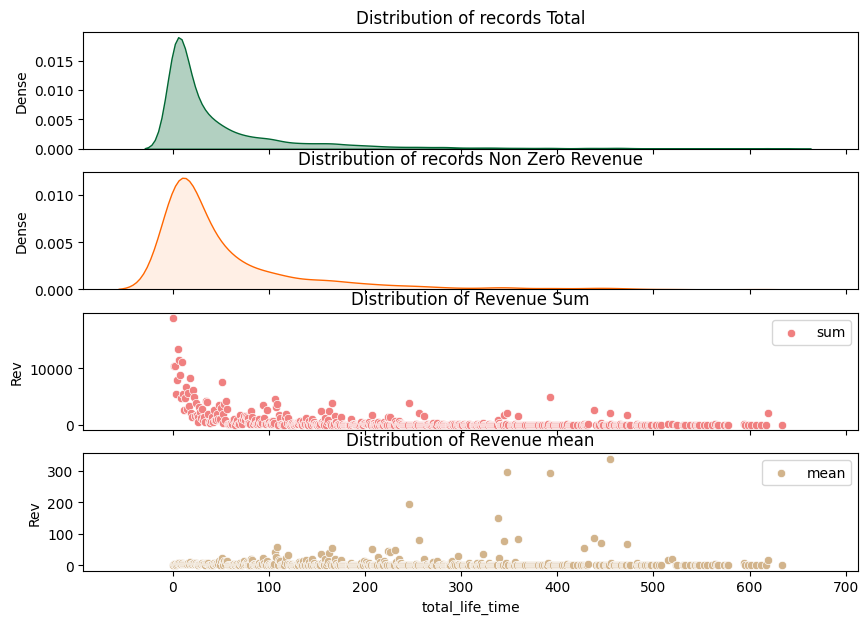

In [ ]:
cols = 'total_life_time'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### revisit_dur_time
- 첫 재방문까지 걸린 시간을 나타내는 피처
- visit_number와 유사한 분포를 나타낸다

In [ ]:
cols = 'revisit_dur_time'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### weekdaily_visit
- 요일별 방문 횟수를 측정한 피처
- 대부분의 구매가 요일에 1번 방문한 유저에게서 발생했음을 확인.
- 또한 2회 부근에서 구매자 수가 상승하는 경향 확인

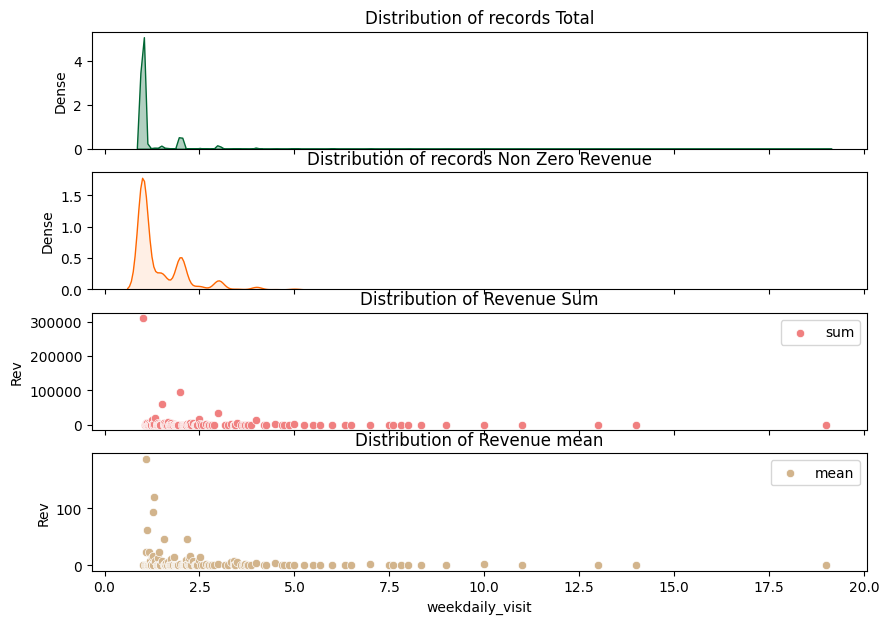

In [ ]:
cols = 'weekdaily_visit'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### monthly visit
- 월별 방문 횟수를 추적하는 피처
- 15회 이전까지 평균 구매액이 양의 상관관계를 가짐을 확인.

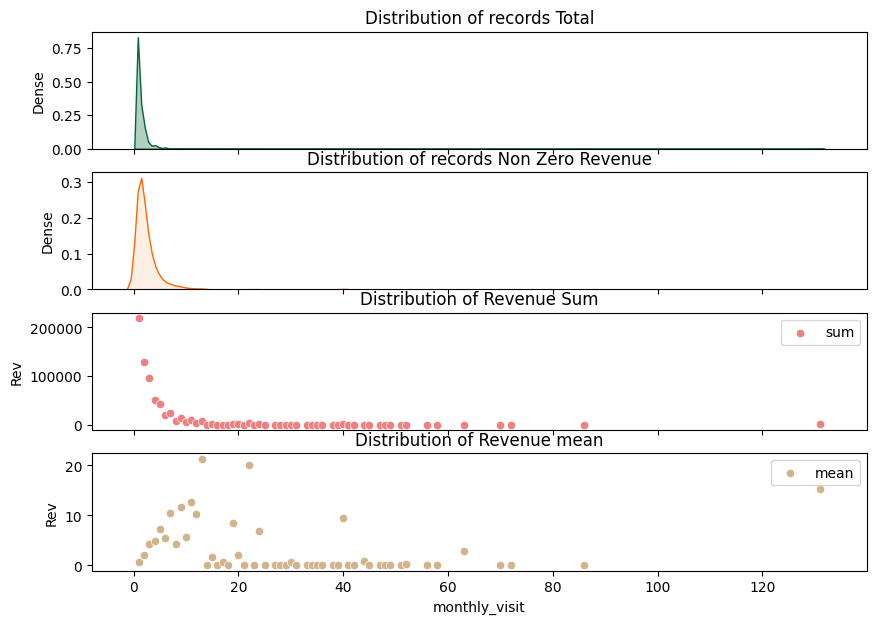

In [ ]:
cols = 'monthly_visit'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### hits_contentGroup.contentGroup2_Ent
- 조회 상품군의 수를 Hit 수와 비교하여 엔트로피화 한 피처.
- 구매하고자 하는 품목이 명확한 경우와 여러 상품들을 둘러보며 구매하는 경우로 나뉘는 행동양식을 포착할 수 있음.
- 해당 피처는 이후 머신의 가장 주요한 피처 2위로 활용됨

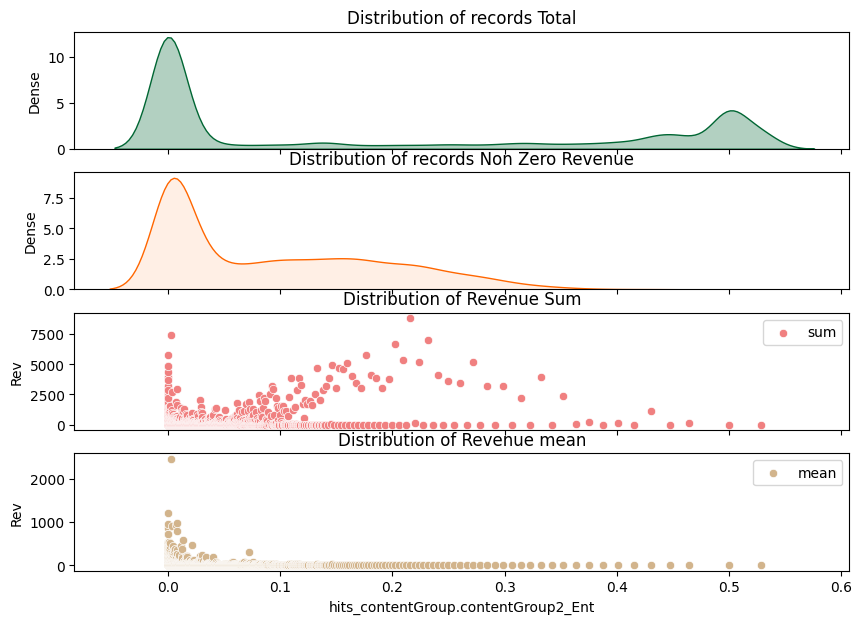

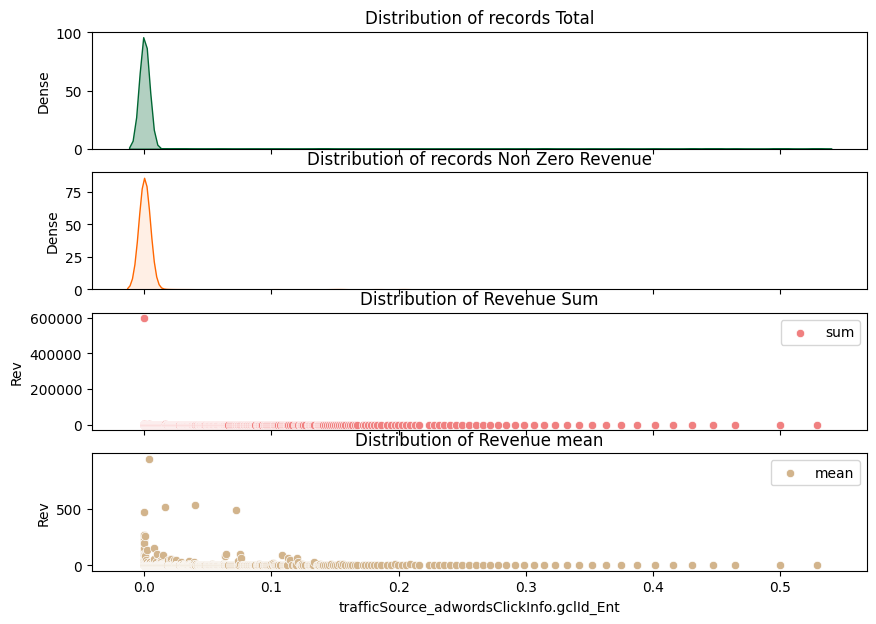

In [ ]:
ENT = [
'hits_contentGroup.contentGroup2_Ent',
'trafficSource_adwordsClickInfo.gclId_Ent',
]
for i in ENT:
  cols = i
  kde_scatter(cols, data, figsize_x=10,figsize_y=7)


### channelGrouping
유저의 사이트 유입 채널을 카테고리별로 보여주는 명목형 변수이다. 유입채널별로 명확한 성향차이를 보인다.
- 변수 설명
  - Organic Search : 자연검색 유입. 대체로 높은 매출을 일으킨다.
  - Social : 광고 외의 SNS를 통한 유입. 
  - Direct : URL 입력을 통한 직접 유입. 이 루트로 유입되는 유저는 재방문일 확률이 매우 높다.
  - Referral : 검색엔진 외의 링크 클릭을 통한 유입. 지인 추천 등이 포함된다.
  - Display : 지면광고 채널을 통한 유입.
  - Paid Search : 검색광고 채널을 통한 유입.
  - Affiliate : 제휴마케팅으로, 외부 웹사이트와 제휴하여 유입을 장려한다.

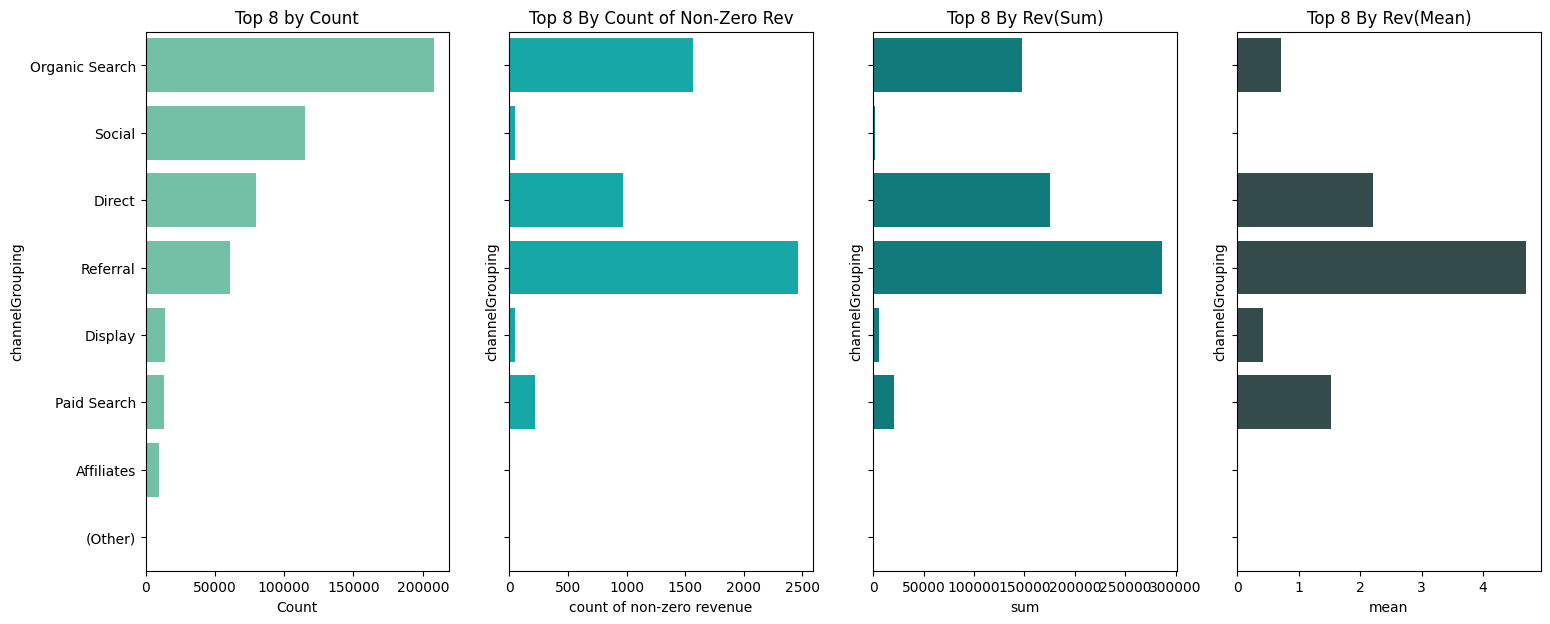

In [ ]:
plot_list = ['channelGrouping']
bar_plot_stats(plot_list,data,y_count=8,figsize_x=18,figsize_y=7)

### device EDA

#### device_operatingSystem
OS 별 매출 기여도가 상이함을 확인할 수 있다. Google Merchandise Store이며, 구글 굿즈를 주로 판매하는 점을 미뤄보아, 개발자들이 주요 수요자임을 추측할 수 있다. 이는 모바일보다 PC 환경에 주로 상주하는 직업군 특성상 모바일보다 데스크탑의 구매 점유율이 높은 점을 설명한다.

- Windows : 70% 이상의 시장을 점유하고 있는 점을 미뤄보아 가장 많은 유입이 이상하지 않다.
- Macintosh : 2번째로 높은 유입을 담당하고 있으나, 구매자 수, 구매 규모면에서 영향력이 가장 크다.
- Android, iOS : 모바일 구매자가 적은 점이 특이하다. 3,4번째로 유입이 많지만 결제율은 상당히 낮은편.
- Linux : 유입은 하위권이나, 평균구매액이 윈도우보다 높은 점을 볼 수 있다.
- Chrome OS : 유입은 하위권이나, 결제율이 3위이며, 평균결제액은 압도적인 1위이다.


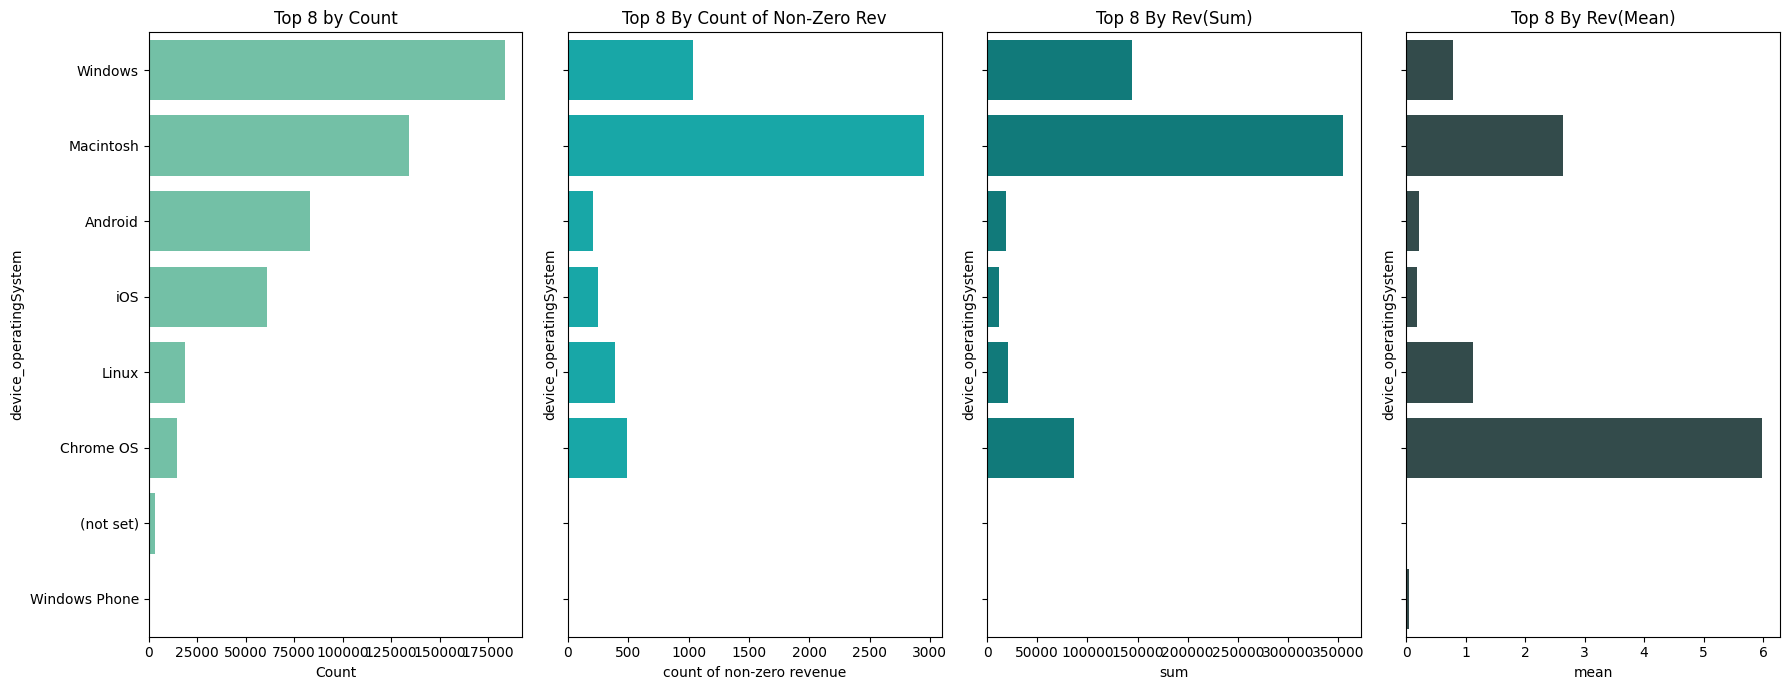

In [ ]:
plot_list = ['device_operatingSystem']
bar_plot_stats(plot_list,data,y_count=8,figsize_x=18,figsize_y=7)

#### device_browser
유저의 디바이스 환경을 나타내는 명목형 변수입니다. 매우 다양한 브라우저가 존재하지만, 매출과 유입을 주도하는 매체가 존재함.
- 크롬, 사파리, 파이어폭스 순으로 인터랙션이 발생했으며, 90%의 점유율을 가진 크롬이 1위임. 다만 FireFox의 경우, 크롬의 5% 정도의 유입 파이를 차지하지만, 평균 매출이 크롬의 약 35% 정도로 높음. 위에서 추측한대로 개발자가 주 수요층일 확률이 높음.

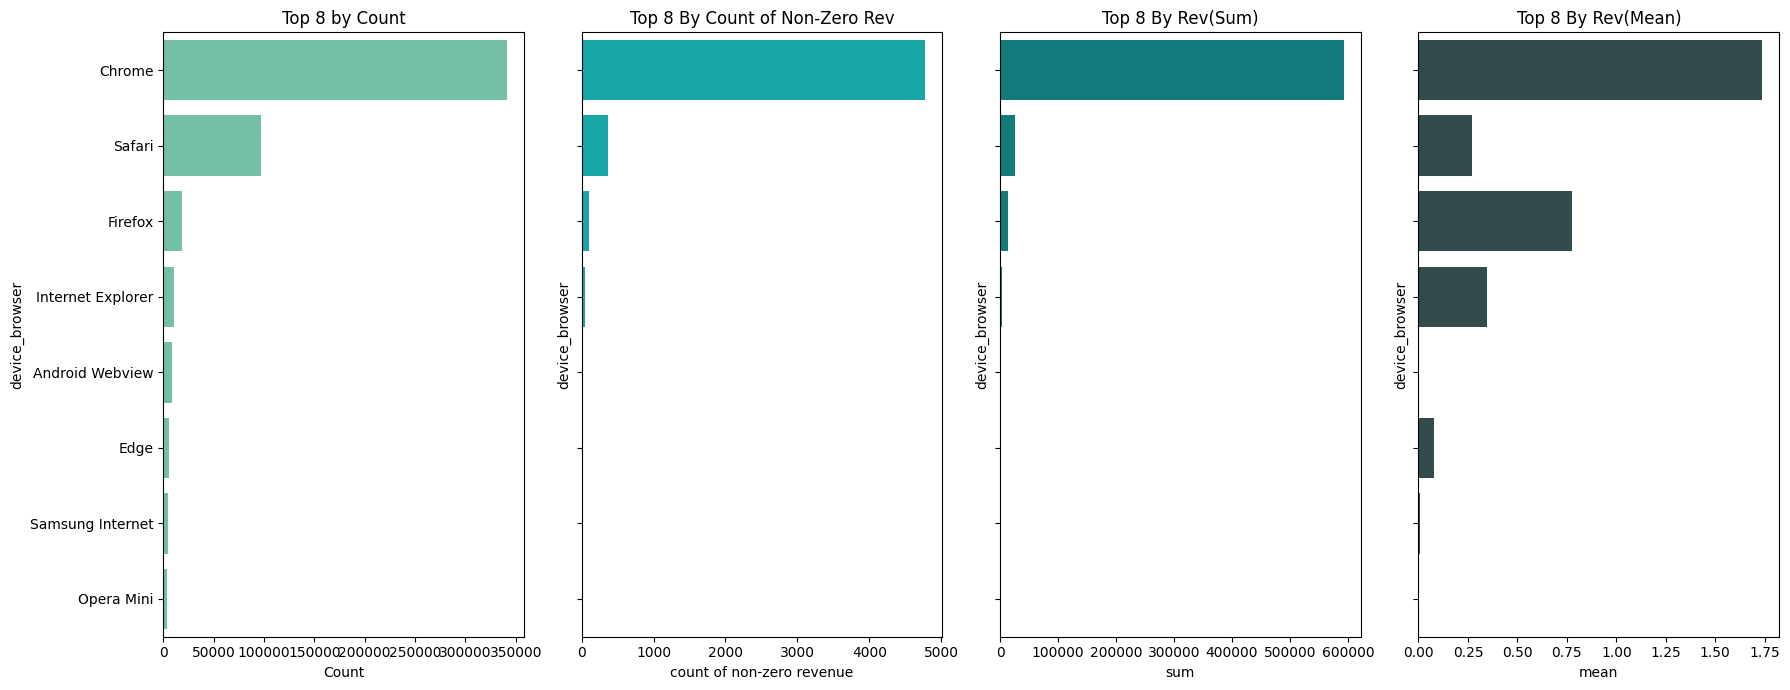

In [ ]:
plot_list = ['device_browser']
bar_plot_stats(plot_list,data,y_count=8,figsize_x=18,figsize_y=7)

### geoNetwork EDA

#### customDimensions_value
대륙단위의 유입 카테고리. 북미의 구매력이 압도적임을 확인할 수 있다.


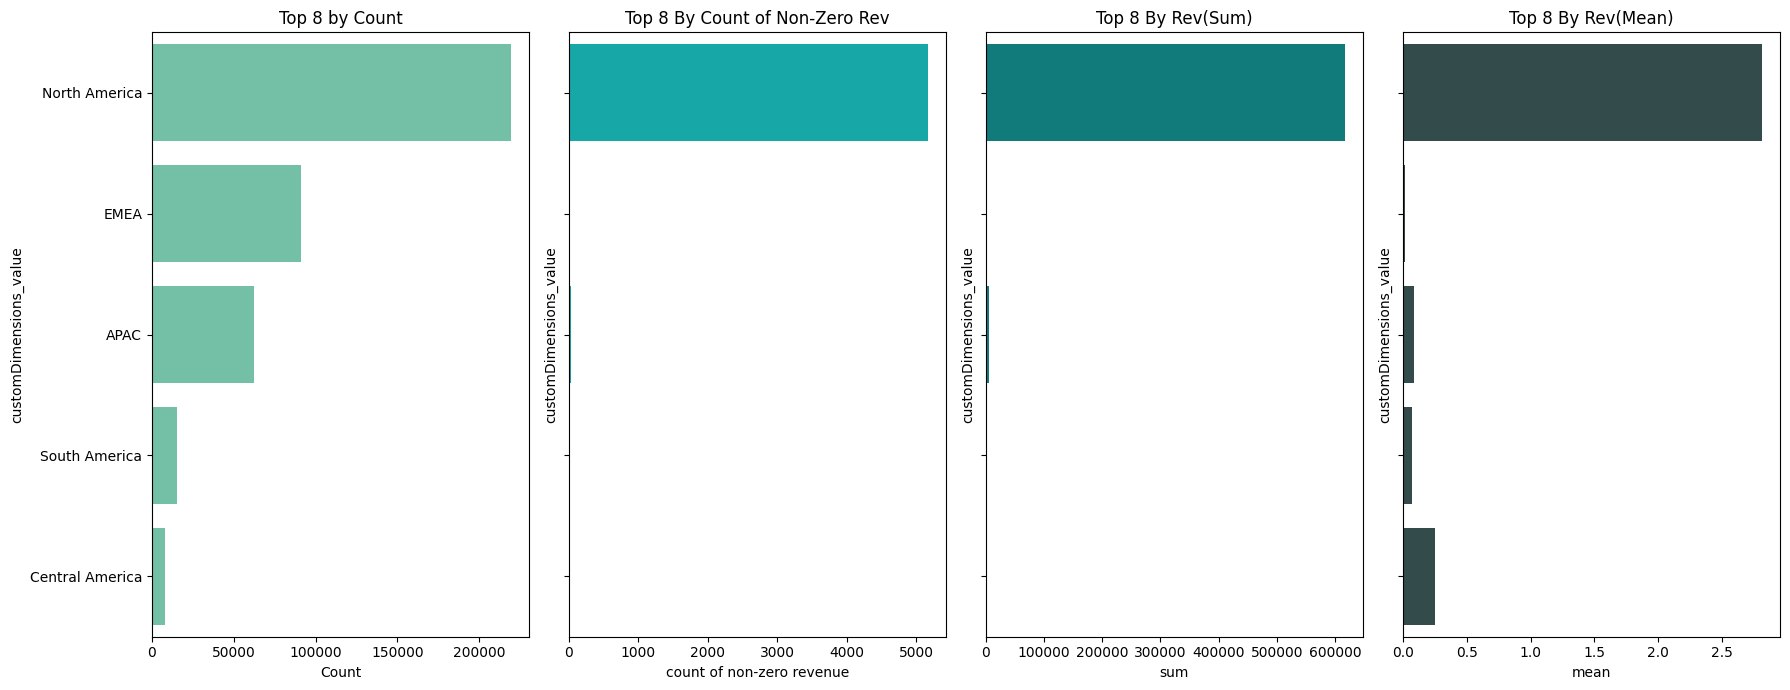

In [ ]:
plot_list = ['customDimensions_value']
bar_plot_stats(plot_list,data,y_count=8,figsize_x=18,figsize_y=7)

#### geoNetwork_continent
대륙 단위의 유입 카테고리. 
- 대부분의 방문객이 아메리카, 아시아, 유럽에 분포해있으며, 아메리카의 매출이 압도적인 상황으로 볼 수 있다. 
- 따라서 국가, 도시 등의 보다 세밀한 뷰를 확인할 필요가 있다.
- 또한 현재로서 아시아와 유럽의 구매전환율이 낮은 상황이므로 개선할 필요가 있다.

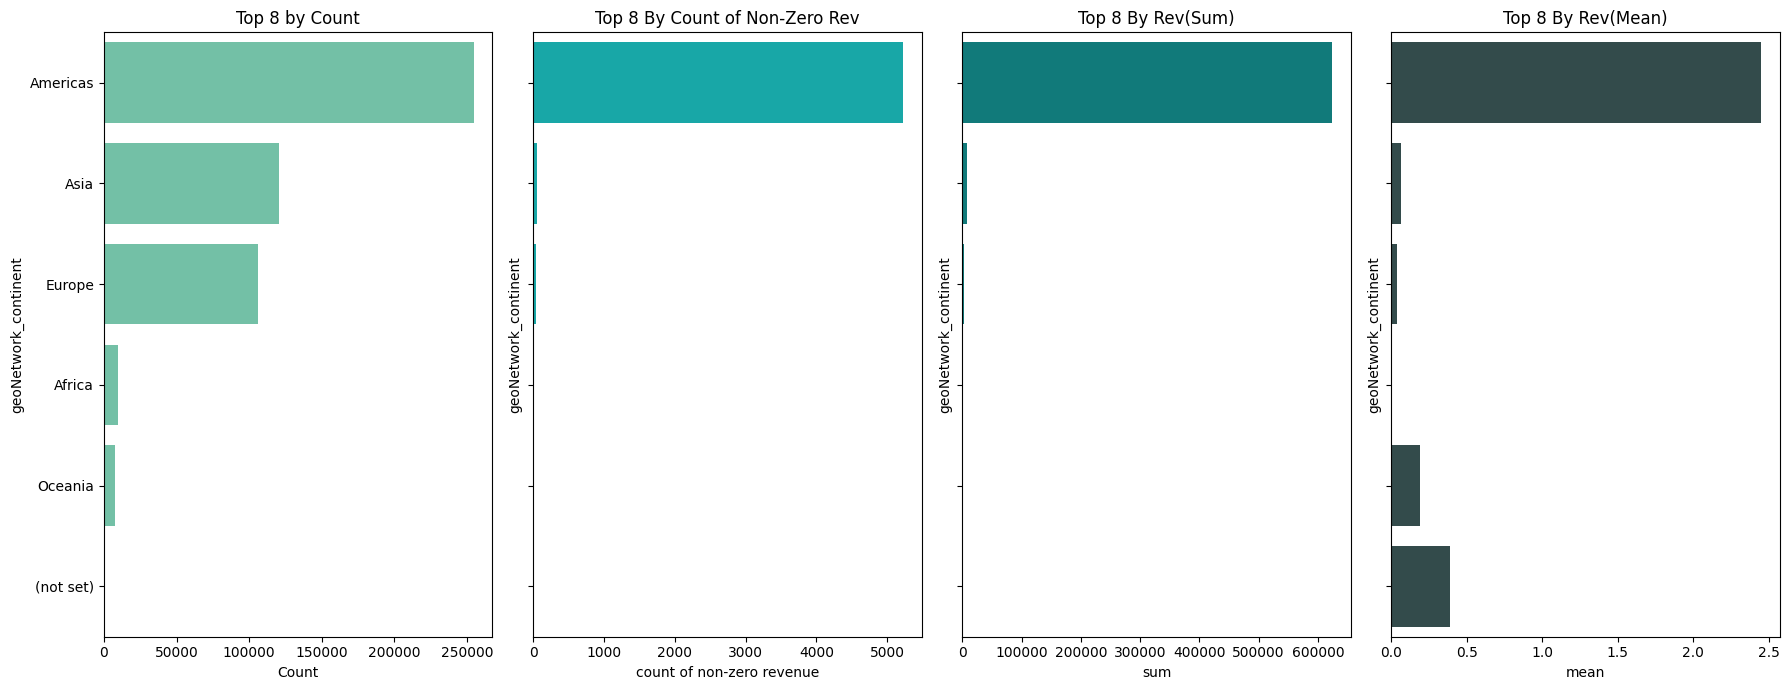

In [ ]:
plot_list = ['geoNetwork_continent']
bar_plot_stats(plot_list,data,y_count=8,figsize_x=18,figsize_y=7)

#### geoNetwork_subContinent
- 위와 같이, 아시아와 유럽의 구매를 장려할 필요가 있다.

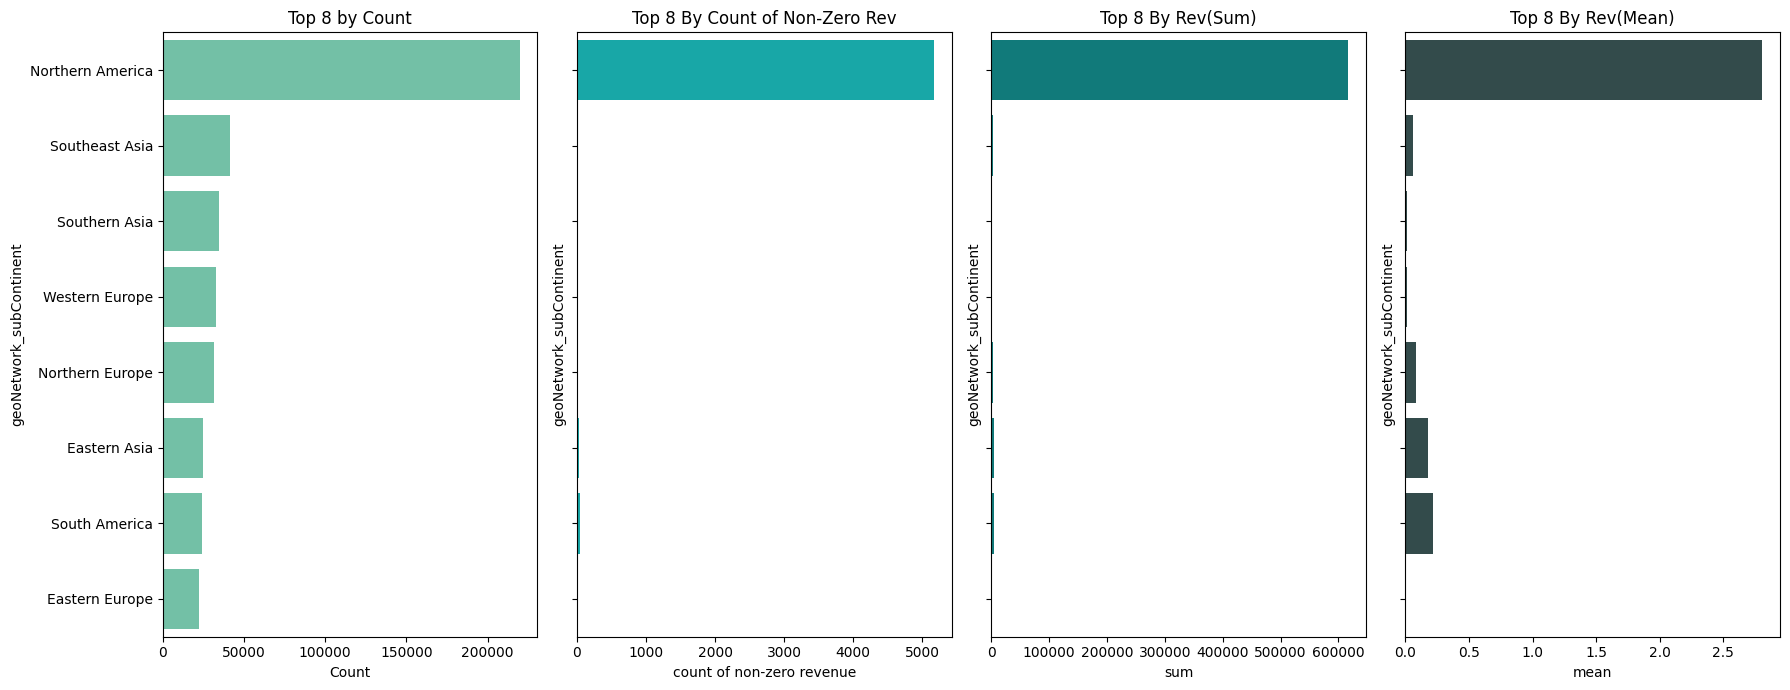

In [ ]:
plot_list = ['geoNetwork_subContinent']
bar_plot_stats(plot_list,data,y_count=8,figsize_x=18,figsize_y=7)

#### geoNetwork_country
국가별로 명목형 변수.
- 예상했듯, 미국이 지표상 압도적인 점유율을 보인다.
- 캐나다의 경우 평균 매출이 유입대비 상상히 높아, 개인별 매출액을 추가적으로 확인할 필요가 있다.

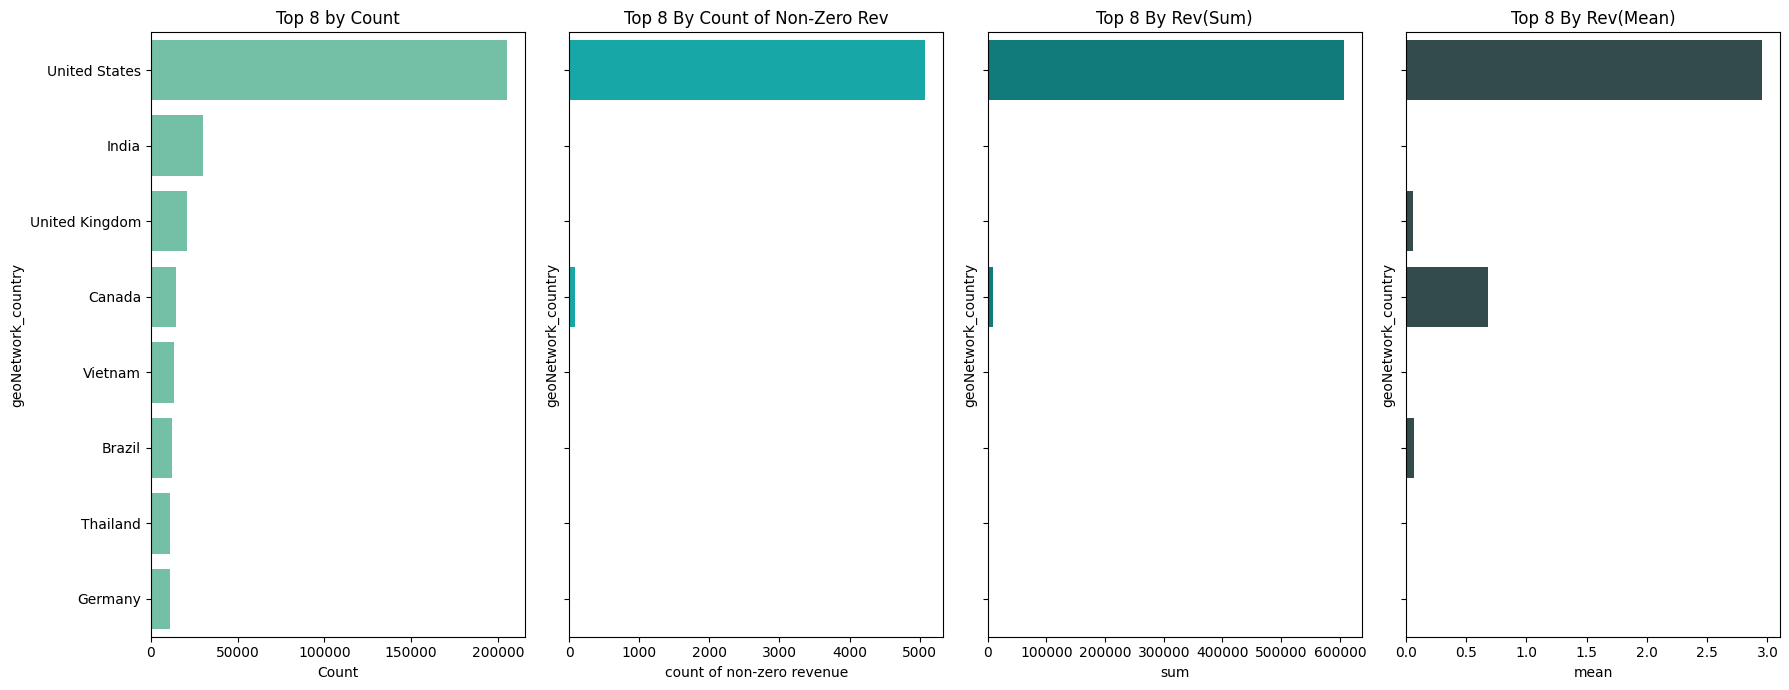

In [ ]:
plot_list = ['geoNetwork_country']
bar_plot_stats(plot_list,data,y_count=8,figsize_x=18,figsize_y=7)

### hits EDA
- GA의 추적 최소단위로 모든 hit가 중첩되어있다. 다양한 방문, 이벤트 등으로 구성된다
- 다만 너무 많은 Garbage 데이터가 포함되어 있다. 따라서 성능에 방해가 되는 요소를 삭제한다.

#### hits_appInfo.exitScreenName
구매자의 이탈 화면 이름. 사이트의 퍼널도 이탈화면에 존재하기 때문에 주요한 단서로 활용할 수 있다.


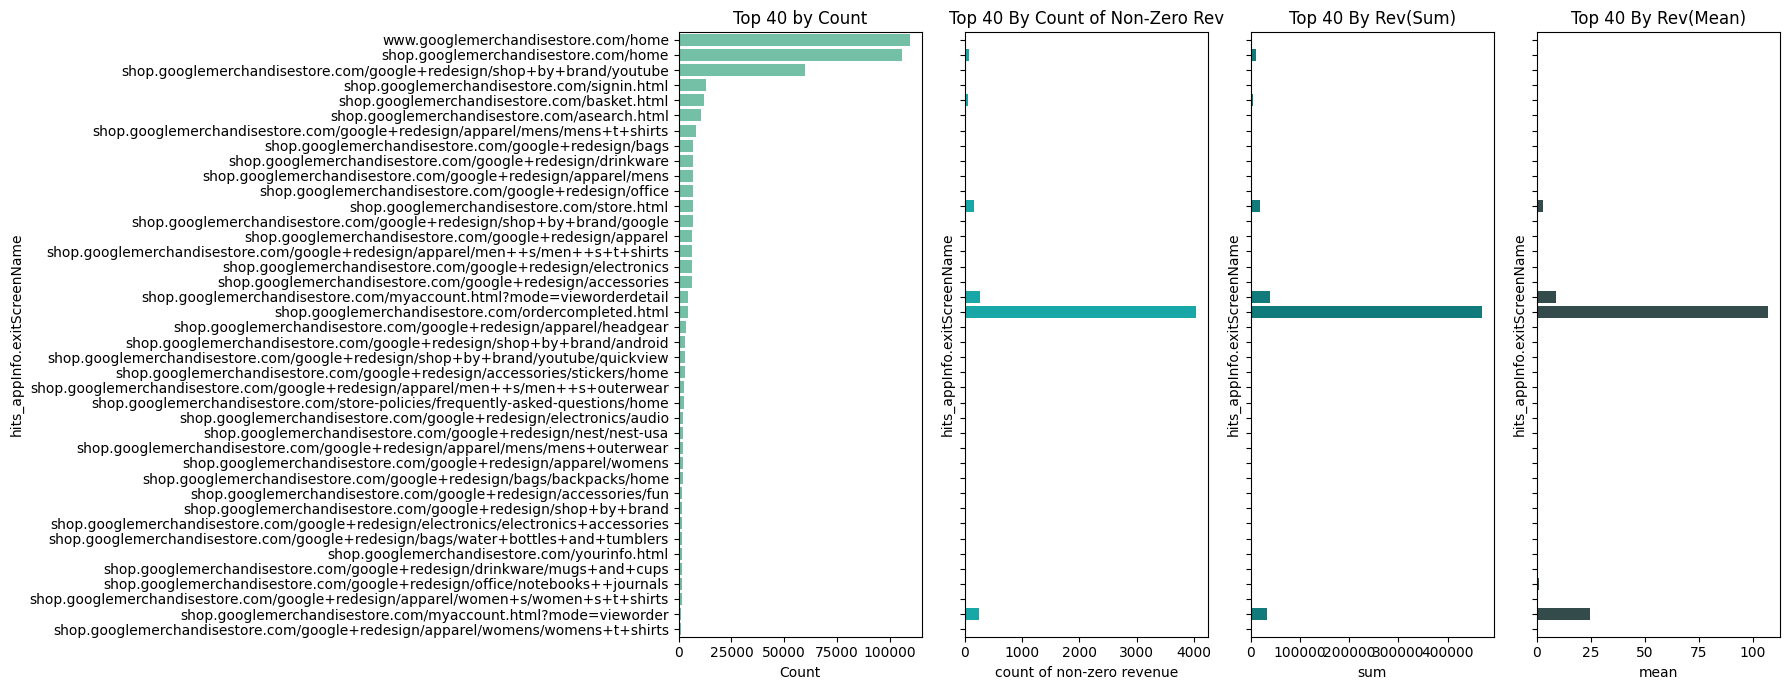

In [ ]:
plot_list = ['hits_appInfo.exitScreenName']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

#### hits_appInfo.landingScreenName
유저의 유입 화면. 

In [ ]:
plot_list = ['hits_appInfo.landingScreenName']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

#### hits_이벤트
향상된전자상거래 이벤트 발생 기록. 상품 노출부터 구매까지의 정보를 추적하는 피처.


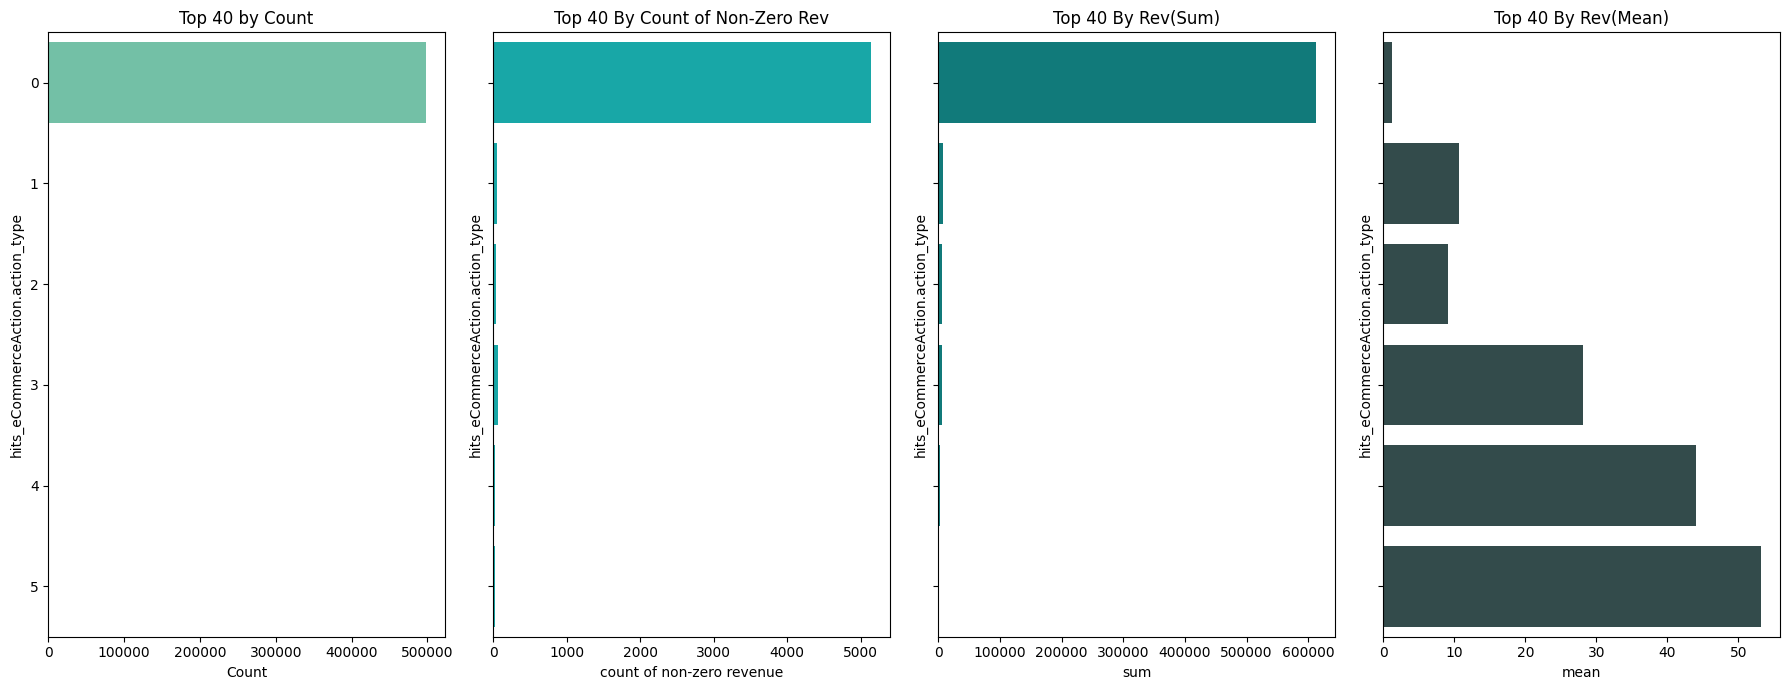

In [ ]:
plot_list = ['hits_eCommerceAction.action_type']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

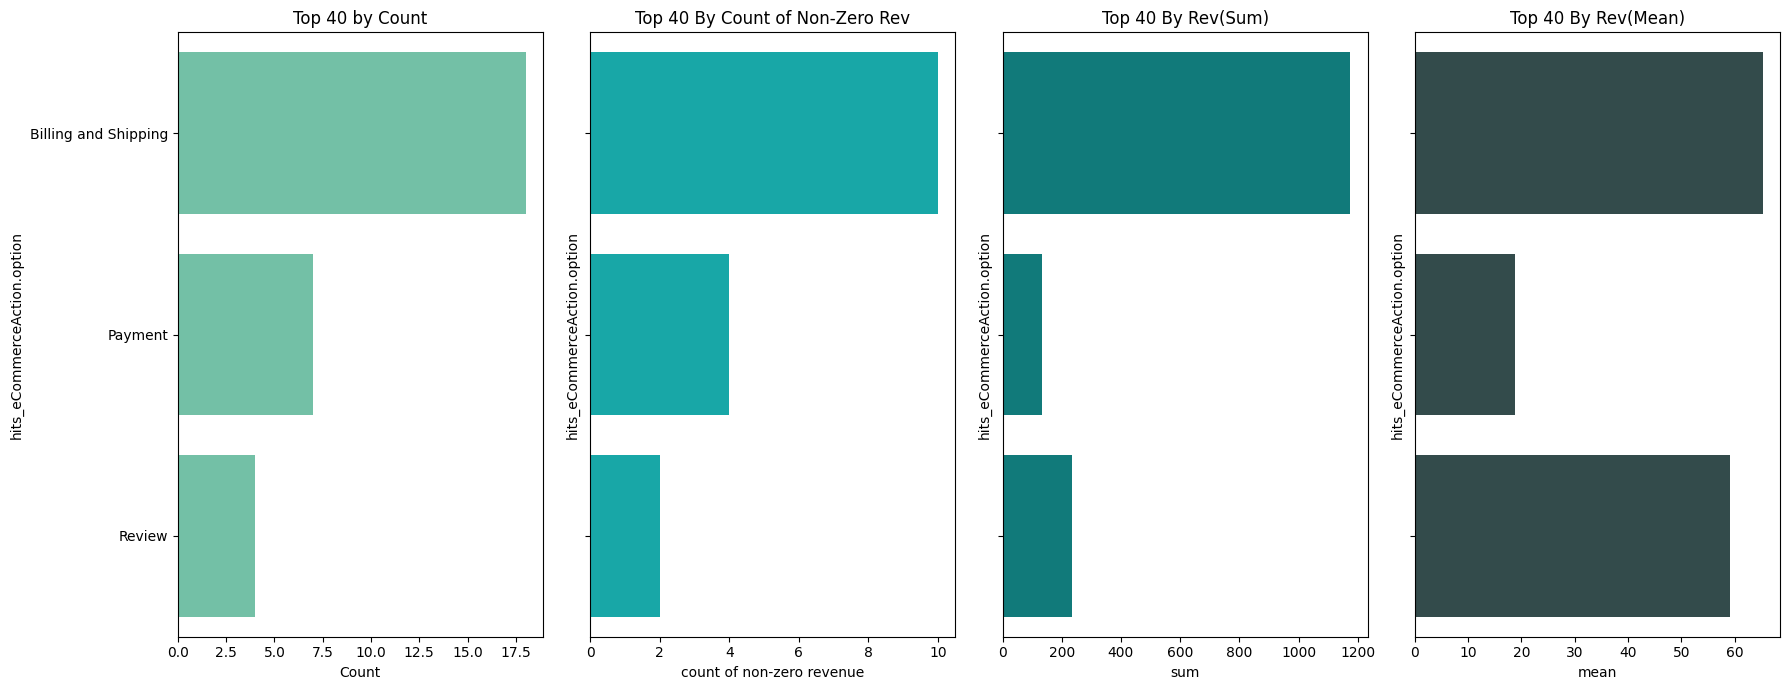

In [ ]:
plot_list = ['hits_eCommerceAction.option']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

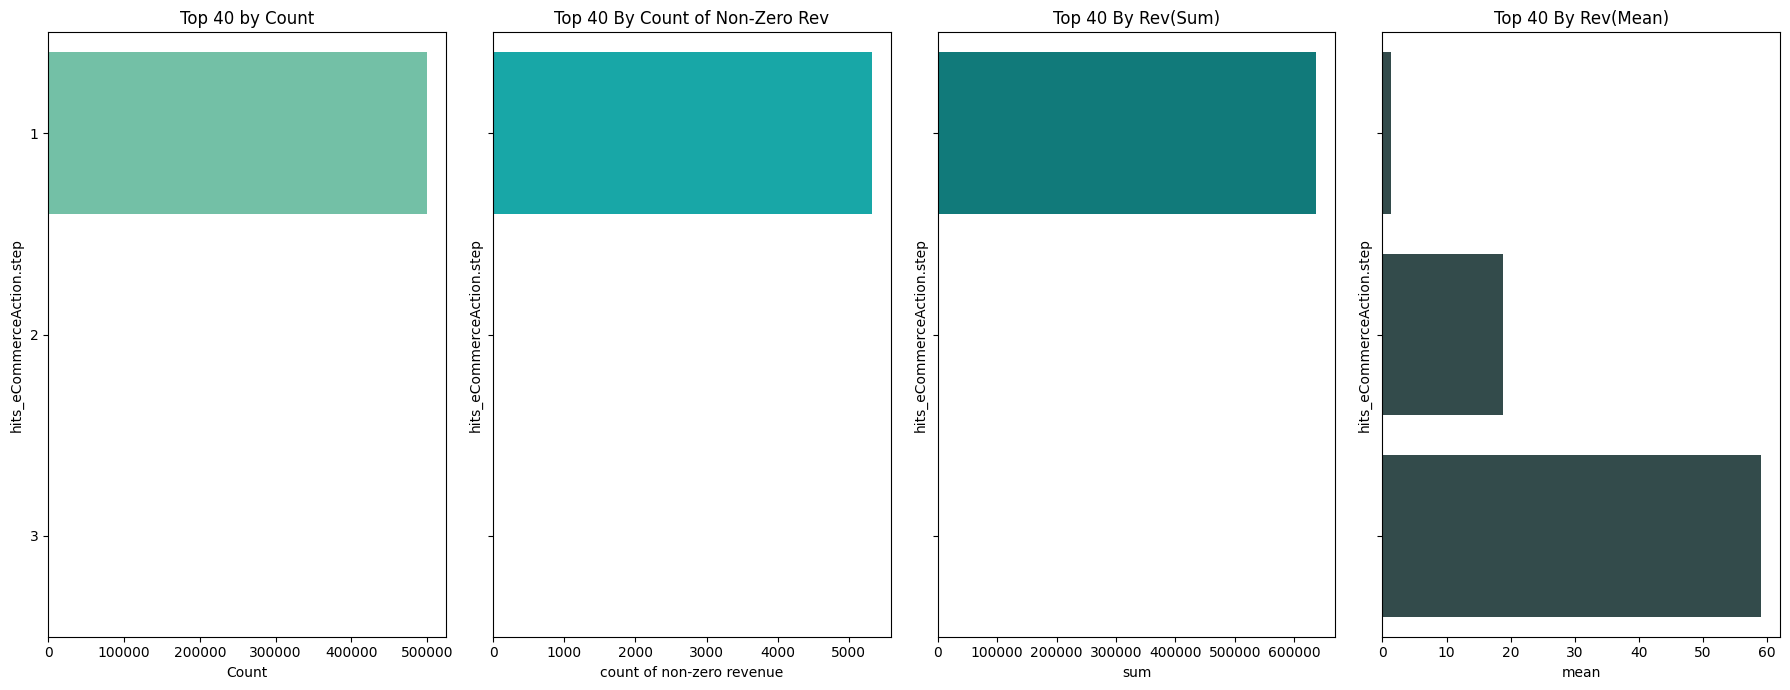

In [ ]:
plot_list = ['hits_eCommerceAction.step']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

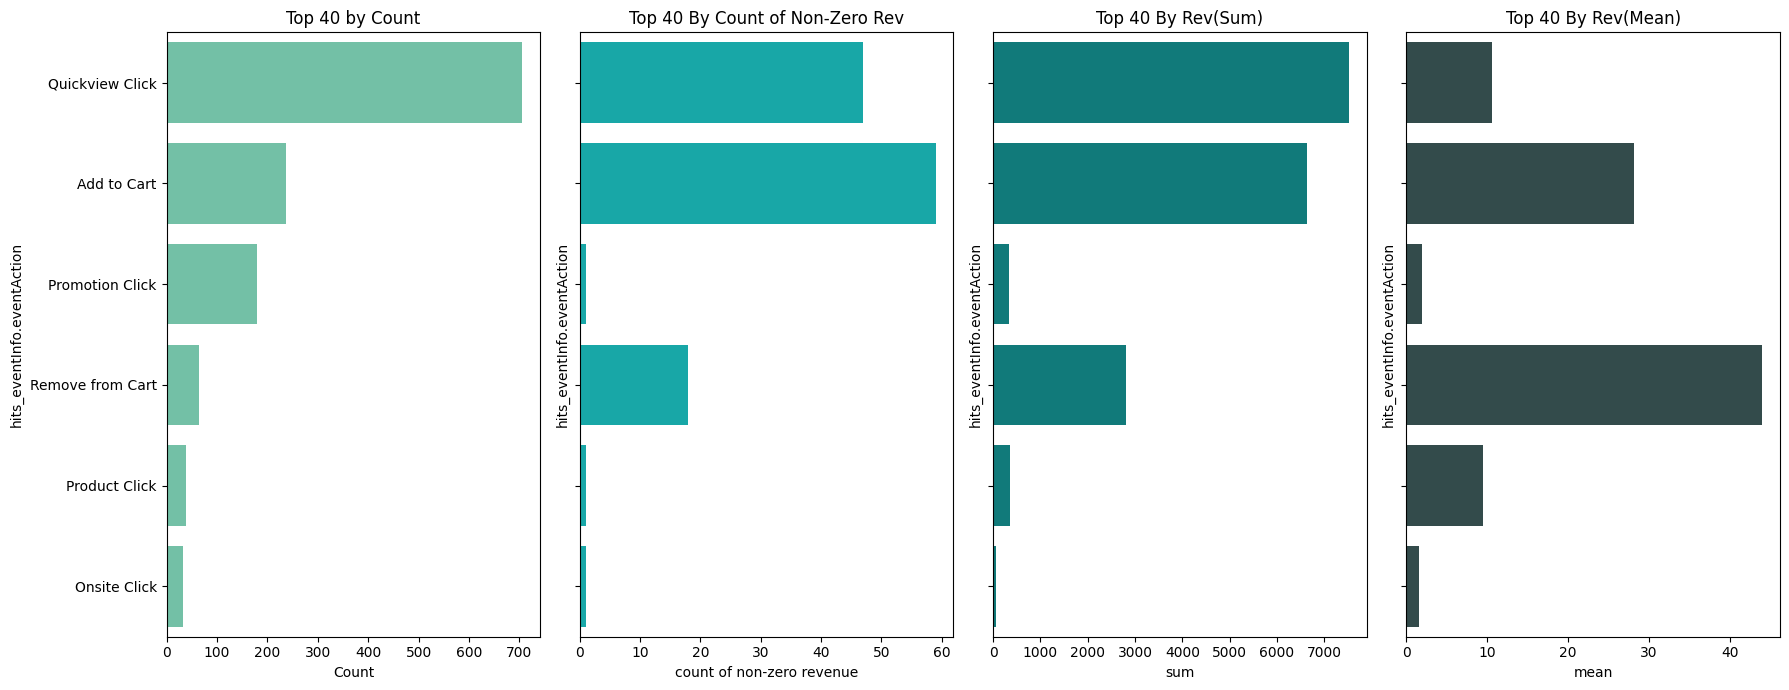

In [ ]:
plot_list = ['hits_eventInfo.eventAction']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

In [ ]:
plot_list = ['hits_eventInfo.eventCategory']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

#### hit 시간 분포
- 시간, 요일 등의 정보를 통해 통계적인 차이점을 확인할 수 있다

In [ ]:
cols = 'hits_hour'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

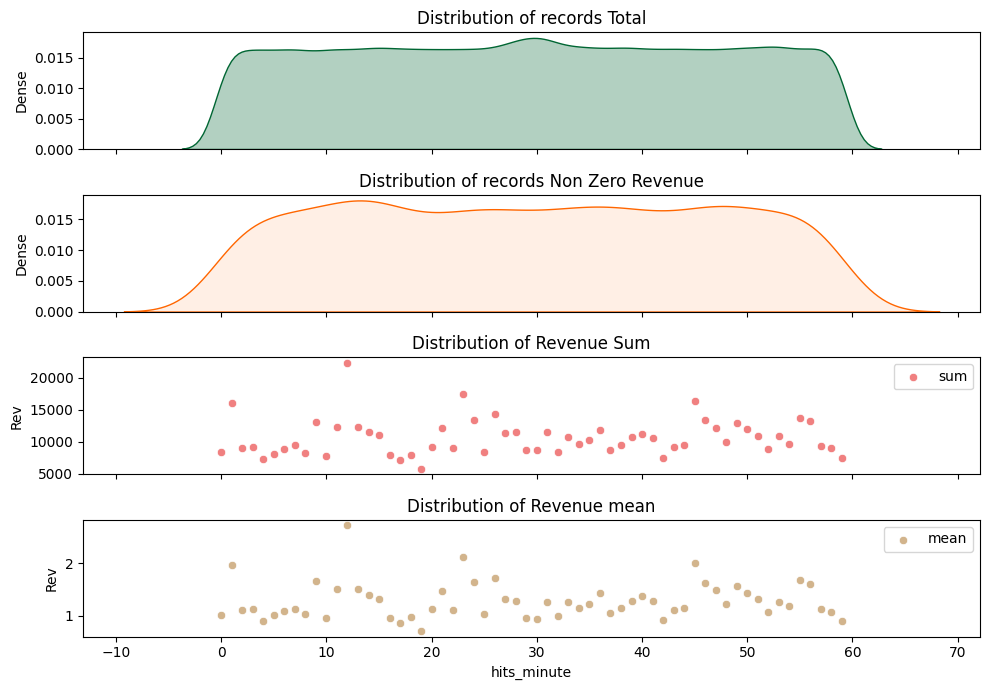

In [ ]:
cols = 'hits_minute'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### hits_상품 정보
- 상세 상품명 정보를 담고있는 피처. 상품별 구매율이 다를 확률이 높으므로 유의미한 피처

In [ ]:
plot_list = ['hits_eventInfo.eventLabel']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

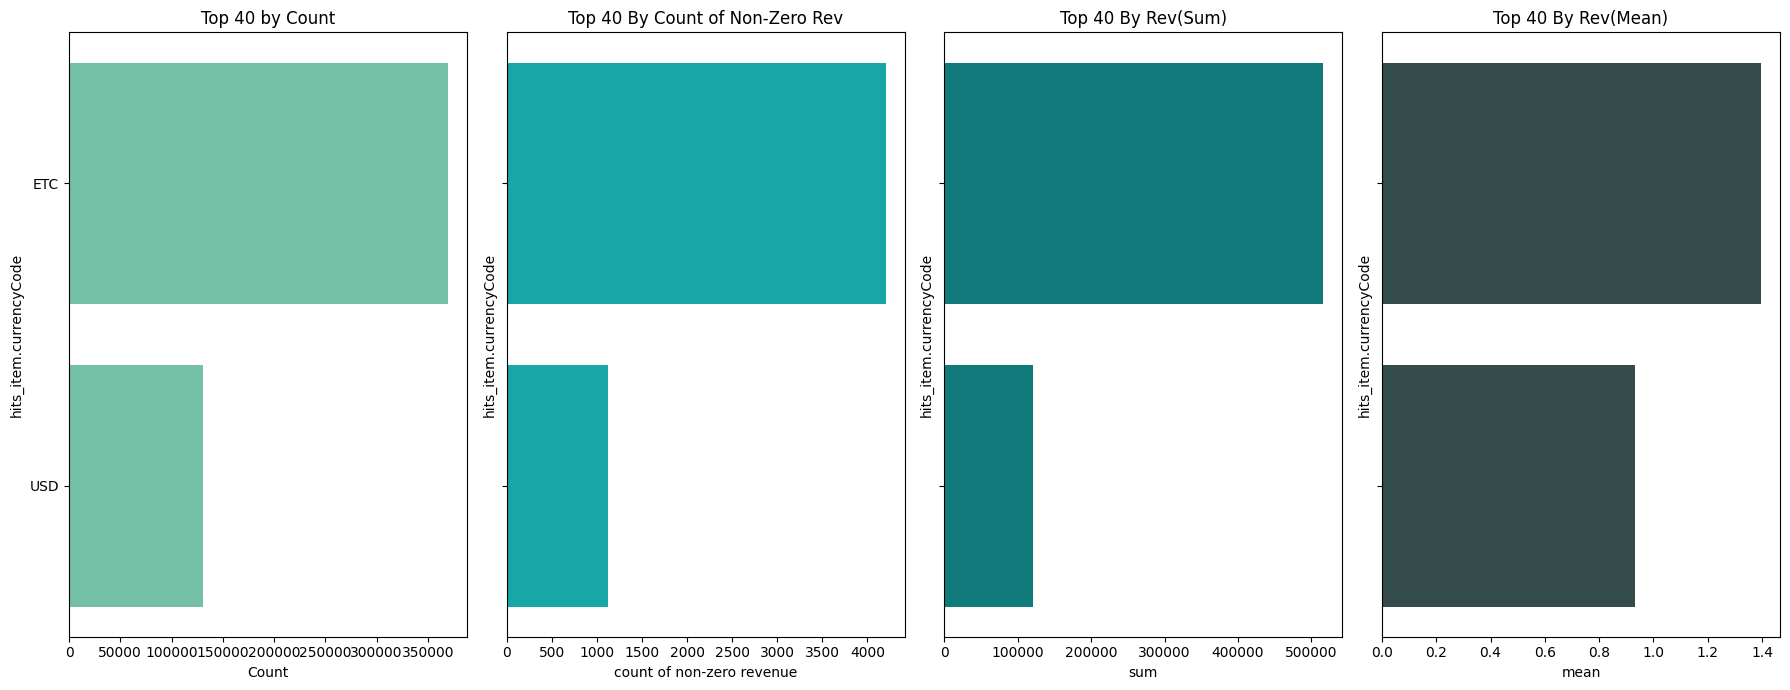

In [ ]:
data['hits_item.currencyCode'].unique()
data['hits_item.currencyCode'].replace('ETC',None,inplace=True)
data['hits_item.currencyCode'].fillna('ETC',inplace=True)
plot_list = ['hits_item.currencyCode']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

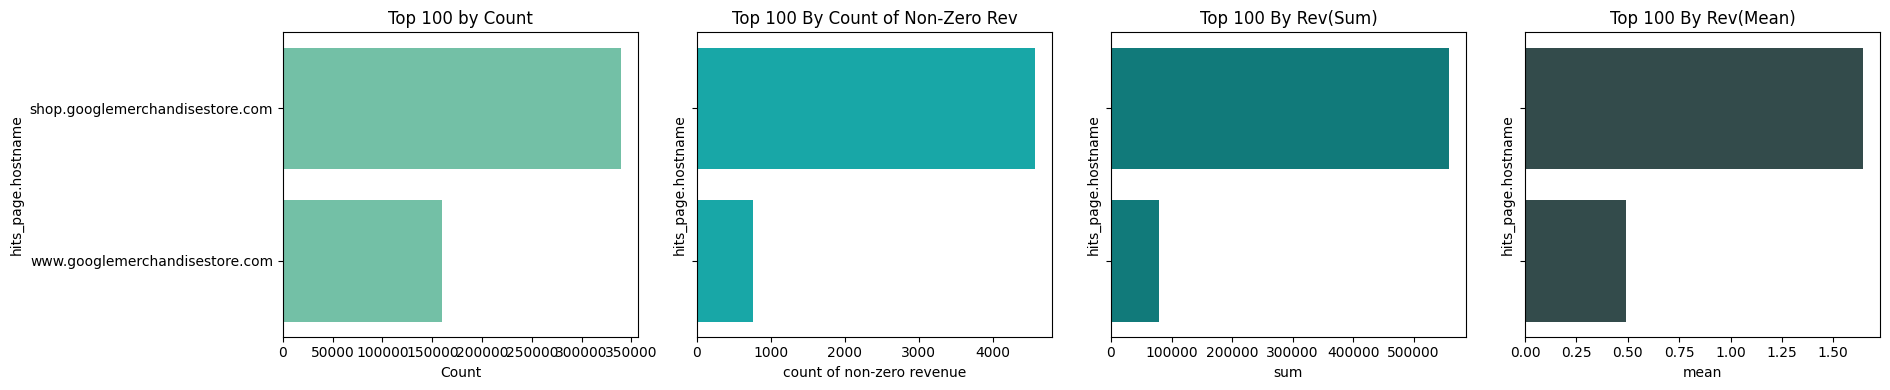

In [ ]:
plot_list = ['hits_page.hostname']
bar_plot_stats(plot_list,data,y_count=100,figsize_x=19,figsize_y=4)

In [ ]:
plot_list = ['hits_page.searchKeyword']
bar_plot_stats(plot_list,data,y_count=50,figsize_x=19,figsize_y=4)

In [ ]:
plot_list = ['hits_page.pagePath']
bar_plot_stats(plot_list,data,y_count=50,figsize_x=19,figsize_y=20)

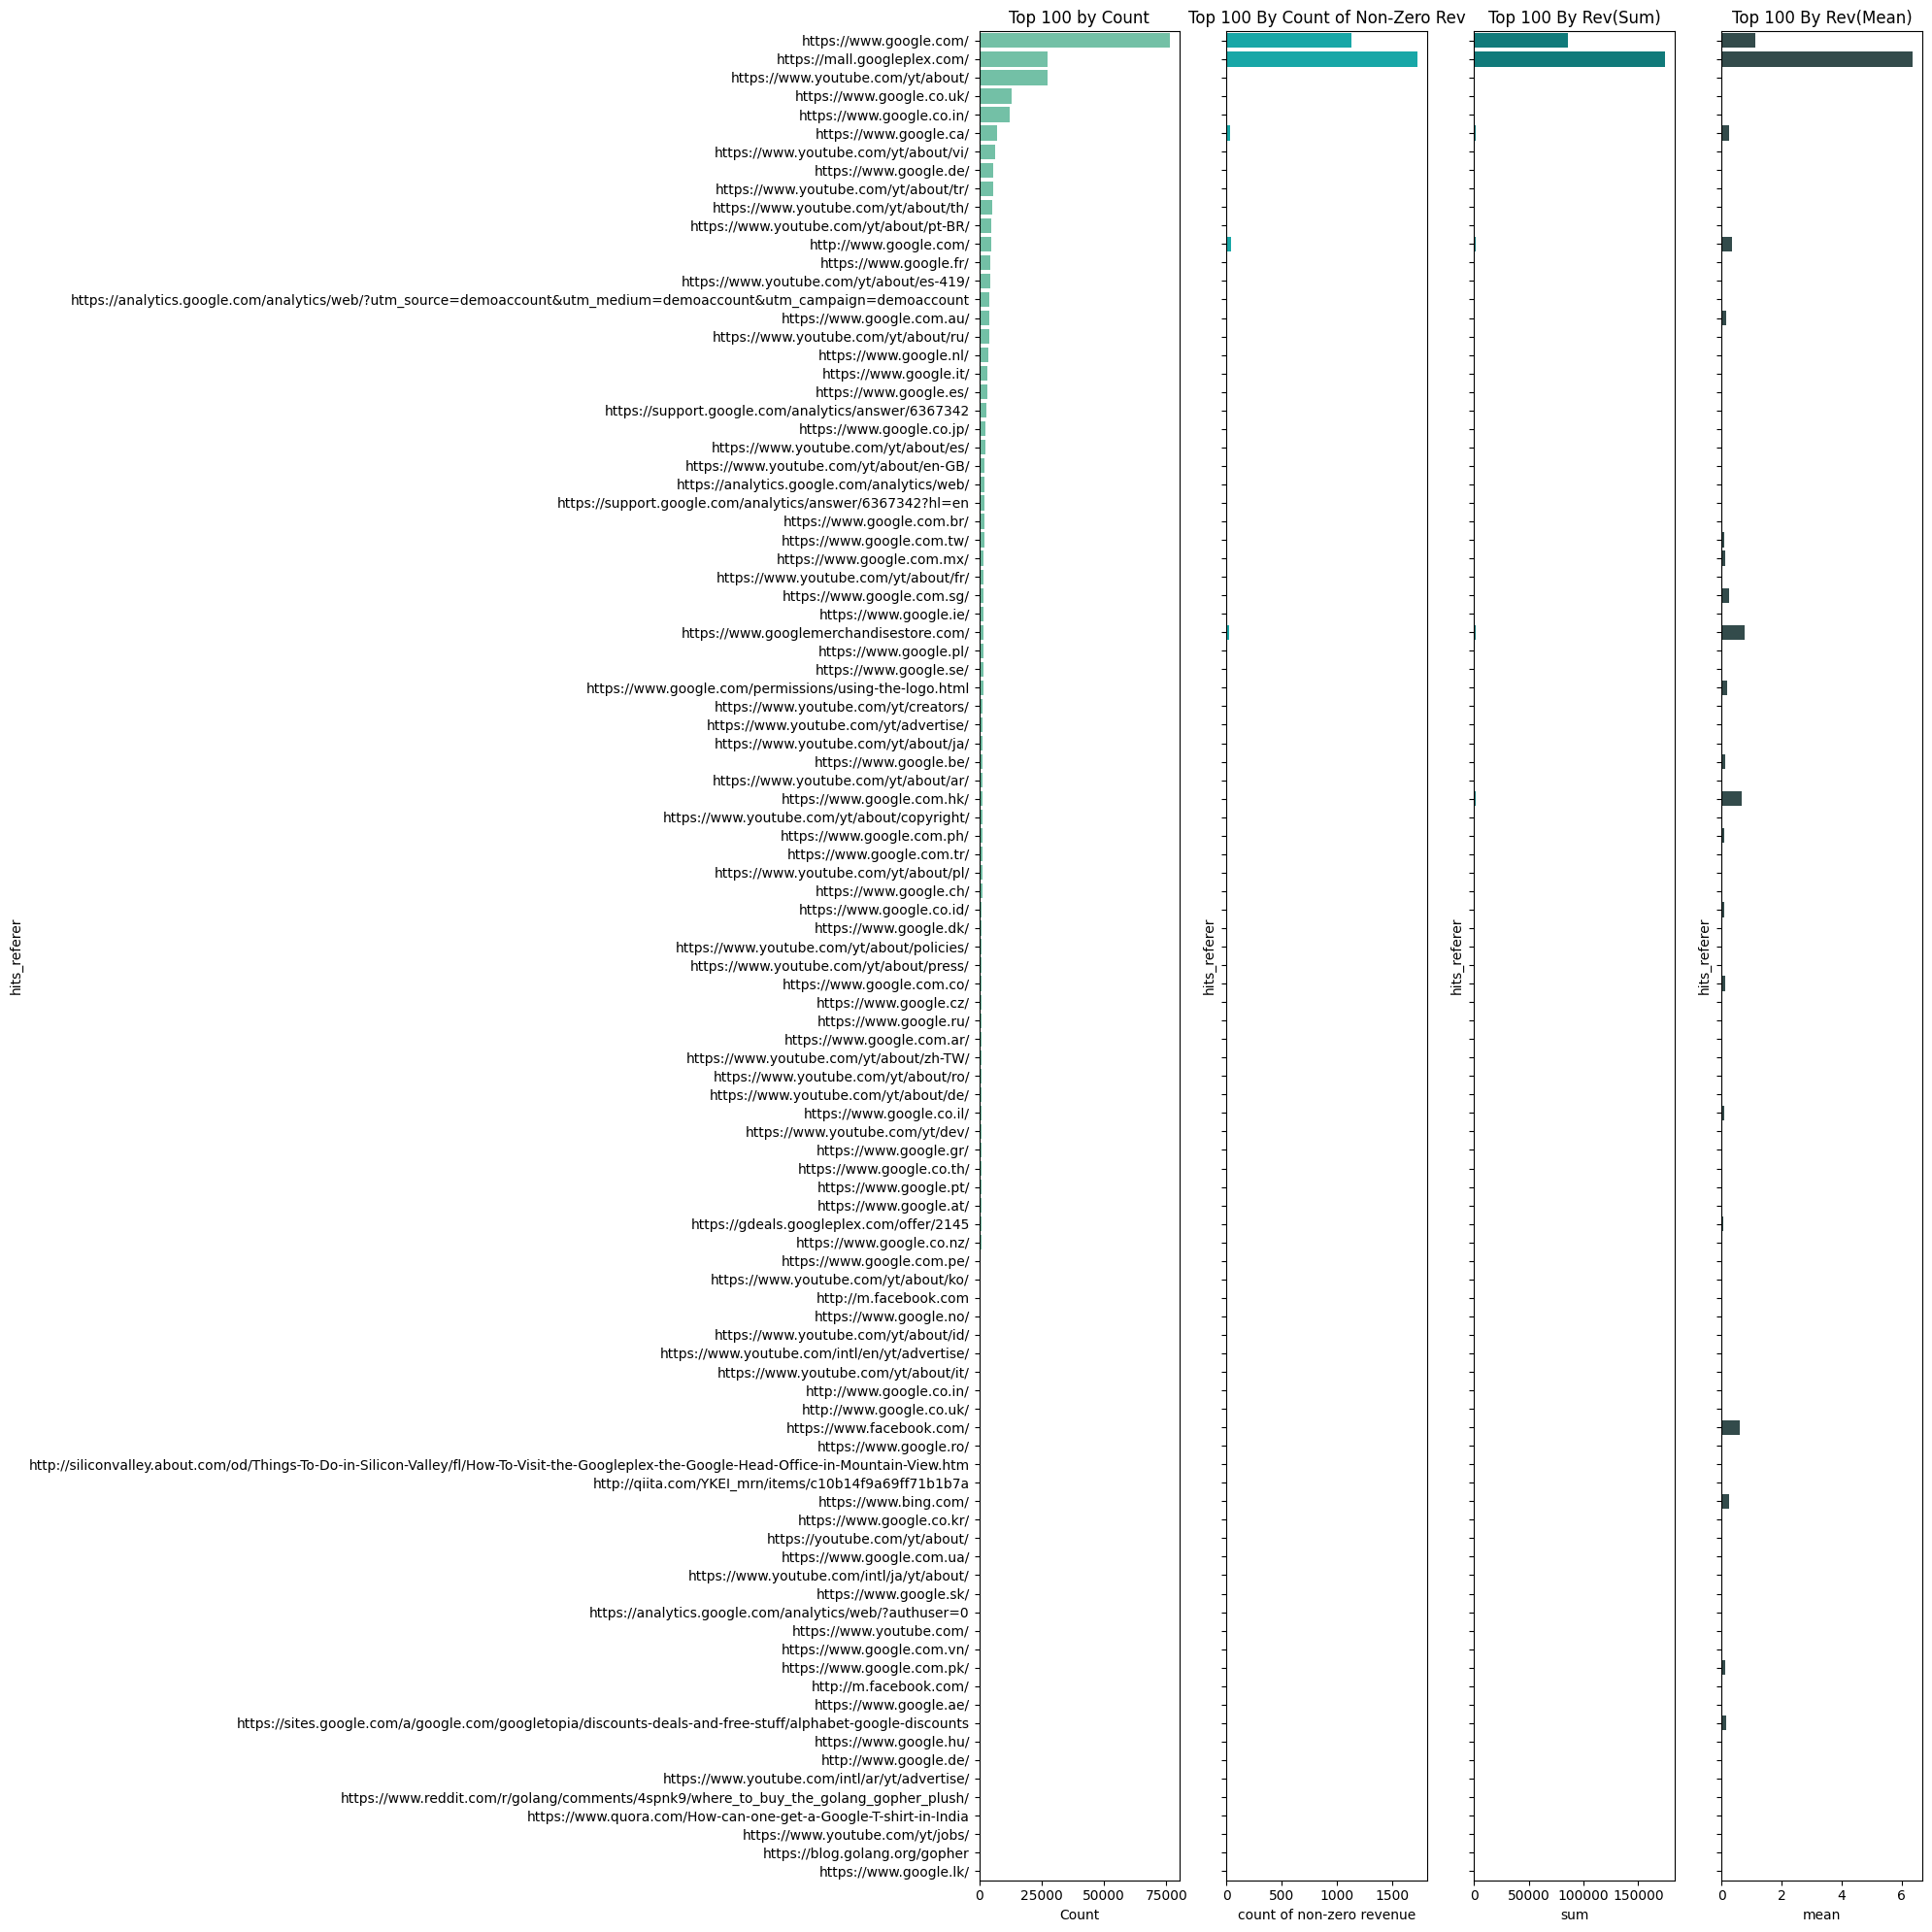

In [ ]:
plot_list = ['hits_referer']
bar_plot_stats(plot_list,data,y_count=100,figsize_x=20,figsize_y=20)

#### hits_무의미한 피처
값에 변화가 없는 피처. 유의미한 피처가 아니다.


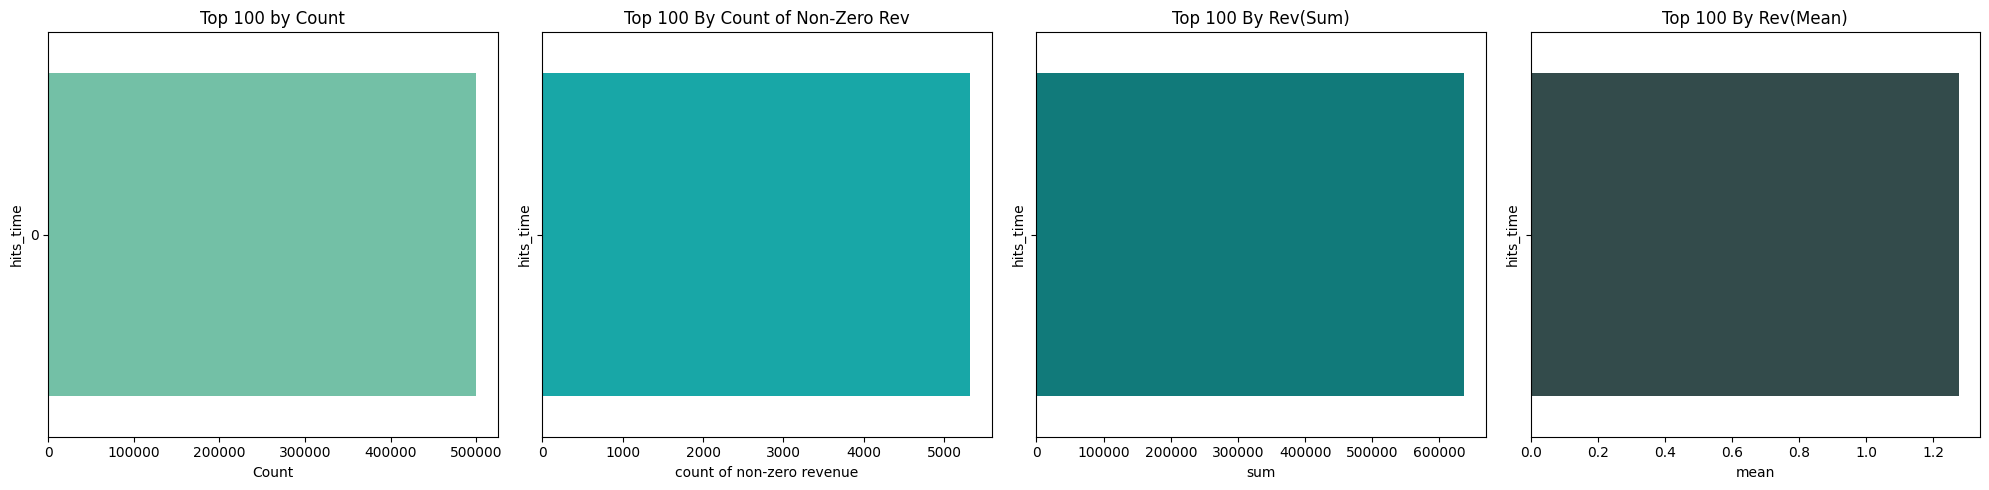

In [ ]:
plot_list = ['hits_time']
bar_plot_stats(plot_list,data,y_count=100,figsize_x=20,figsize_y=5)

In [ ]:
plot_list = ['hits_isEntrance']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

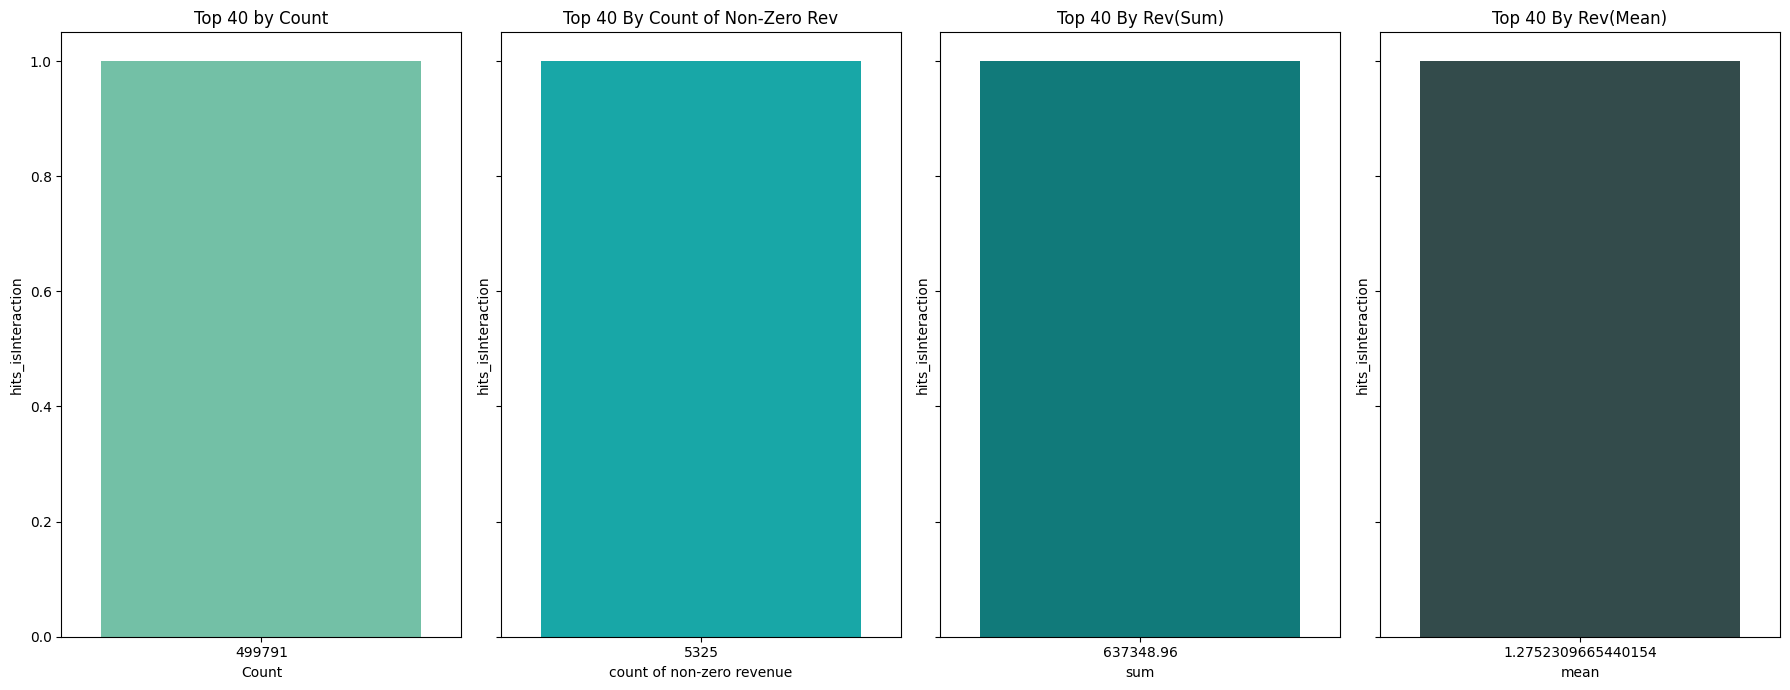

In [ ]:
plot_list = ['hits_isInteraction']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

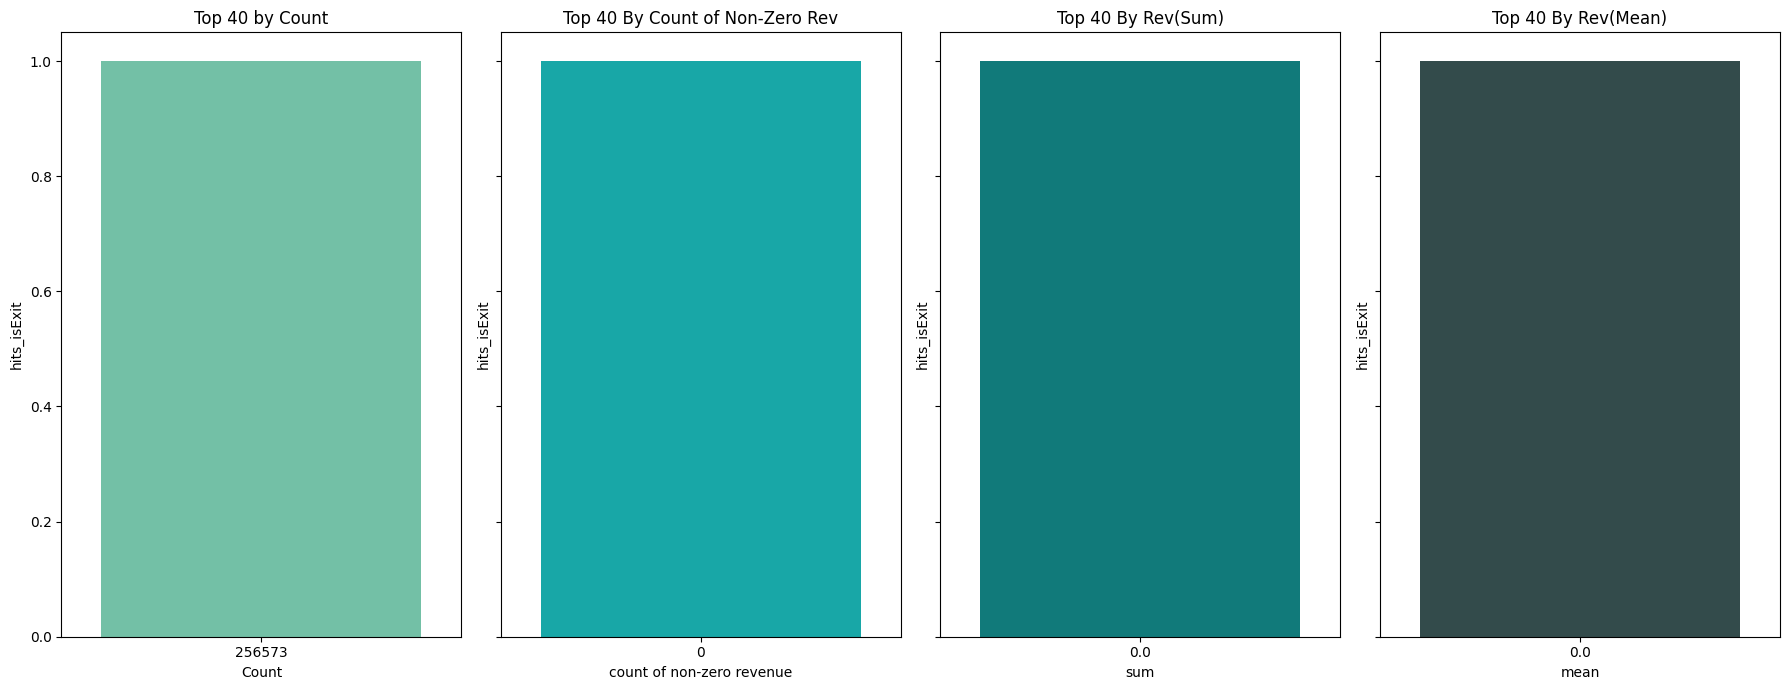

In [ ]:
plot_list = ['hits_isExit']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

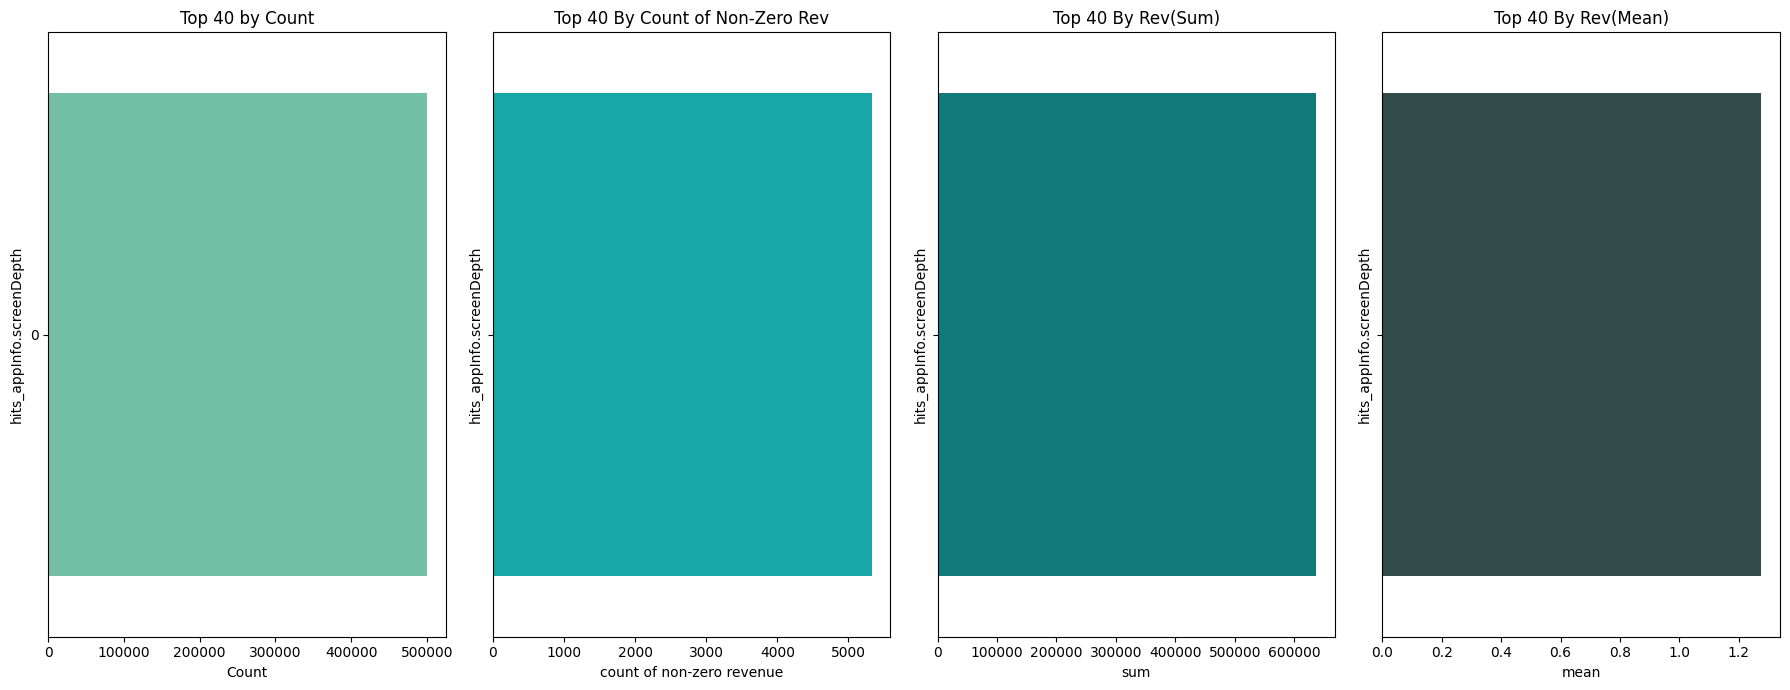

In [ ]:
plot_list = ['hits_appInfo.screenDepth']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

In [ ]:
plot_list = ['hits_page.searchCategory']
bar_plot_stats(plot_list,data,y_count=50,figsize_x=19,figsize_y=4)

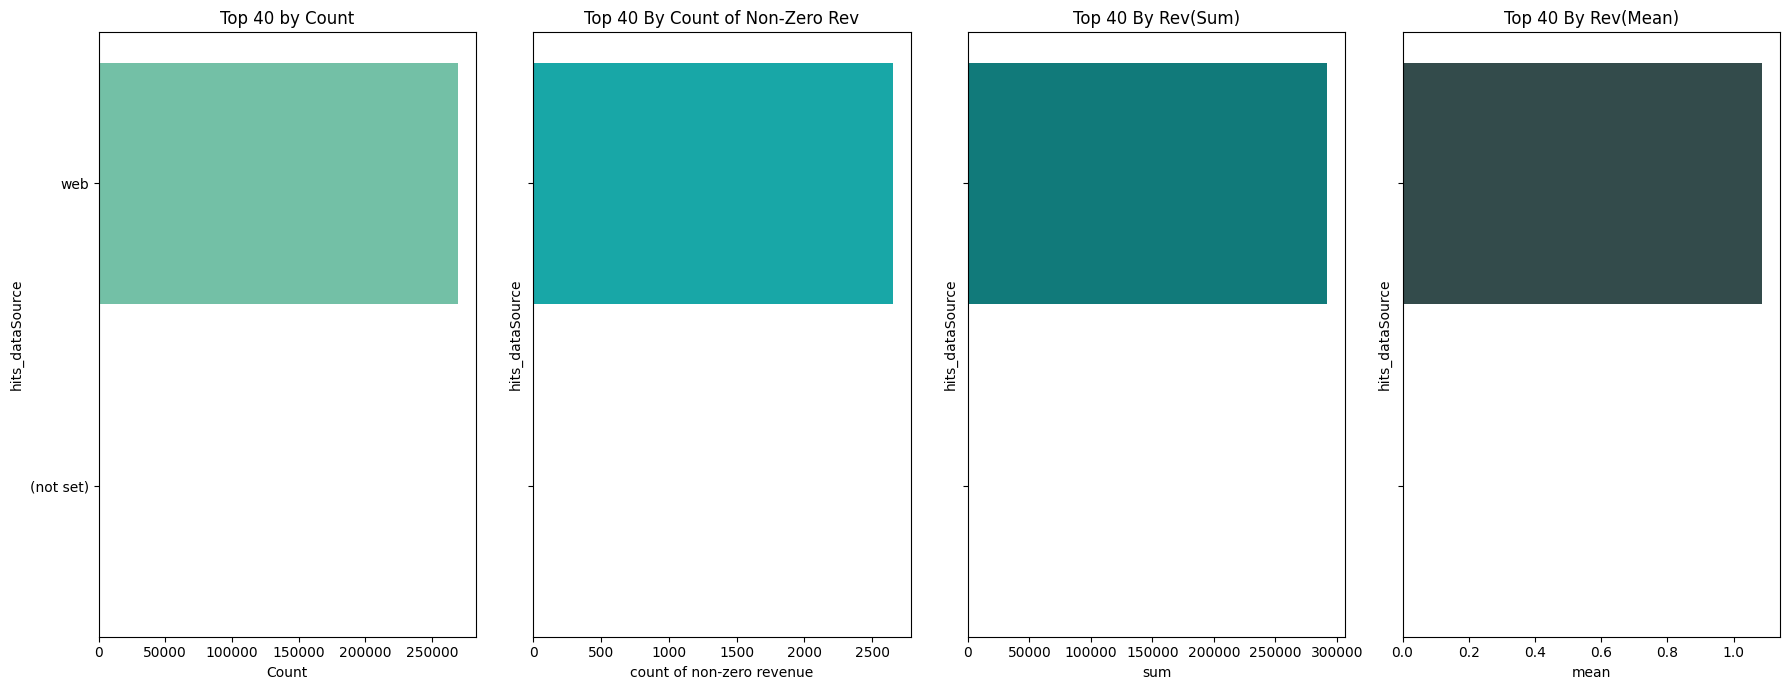

In [ ]:
plot_list = ['hits_dataSource']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

In [ ]:
data['hits_exceptionInfo.isFatal'].value_counts()
# plot_list = ['hits_exceptionInfo.isFatal']
# bar_plot_stats(plot_list,data,y_count=40,figsize_x=18,figsize_y=7)

True    499791
Name: hits_exceptionInfo.isFatal, dtype: int64

### totals EDA

#### totals_newVisits
- 세션의 재방문 유무를 기록하는 피처
- 첫번째 방문이 아닌 재방문에서 대부분의 구매가 발생한다는 가설이 존재하므로, 유의미한 피처.


In [ ]:
plot_list = ['totals_newVisits']
bar_plot_stats(plot_list,data,y_count=100,figsize_x=20,figsize_y=5)

#### totals_sessionQualityDim
- GoogleAnalytics 자체적으로 세션의 퀄리티를 예측하는 피처.
- 구매와 강한 양의 상관관계를 보인다

In [ ]:
cols = 'totals_sessionQualityDim'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)


#### totals_timeOnSite
- 구매자의 분포와 전체 유입의 분포가 위치가 상이하다.
- Garbage 트래픽과 유의미한 트래픽의 차이를 선명하게 확인할 수 있는 피처

In [ ]:
cols = 'totals_timeOnSite'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### totals_hits
- 구매자의 분포와 전체 유입의 분포가 위치가 상이하다.
- Garbage 트래픽과 유의미한 트래픽의 차이를 선명하게 확인할 수 있는 피처

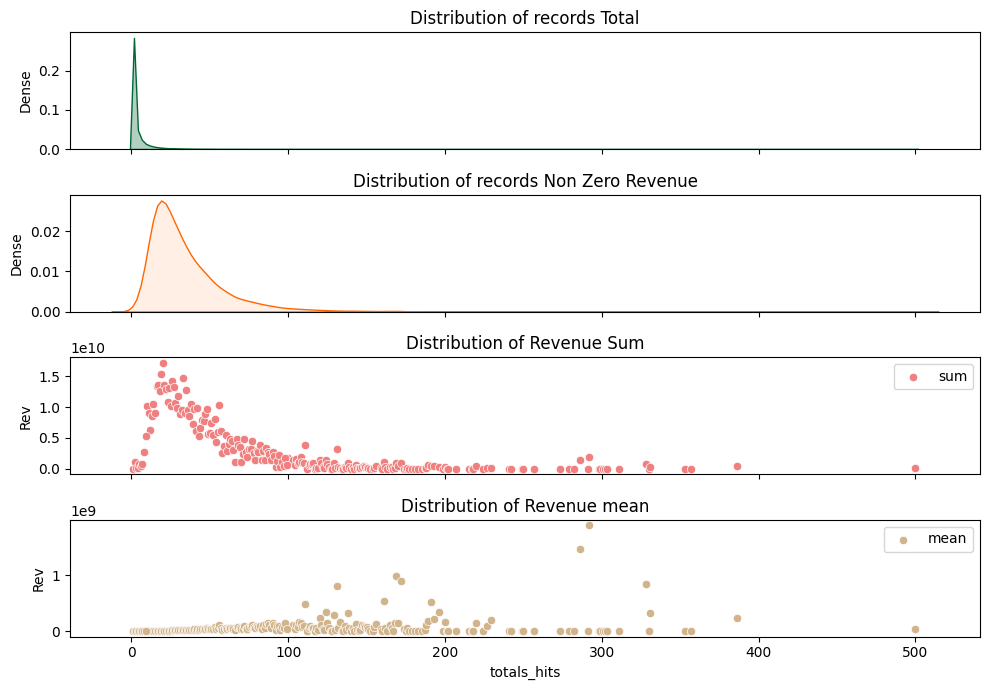

In [ ]:
data.totals_timeOnSite.info()
data.totals_timeOnSite.fillna('0',inplace=True)
data.totals_timeOnSite.replace('0',0,inplace=True)
data.totals_timeOnSite = data.totals_timeOnSite.astype(int)

cols = 'totals_hits'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)


#### totals_pageviews
- 구매자의 분포와 전체 유입의 분포가 위치가 상이하다.
- Garbage 트래픽과 유의미한 트래픽의 차이를 선명하게 확인할 수 있는 피처

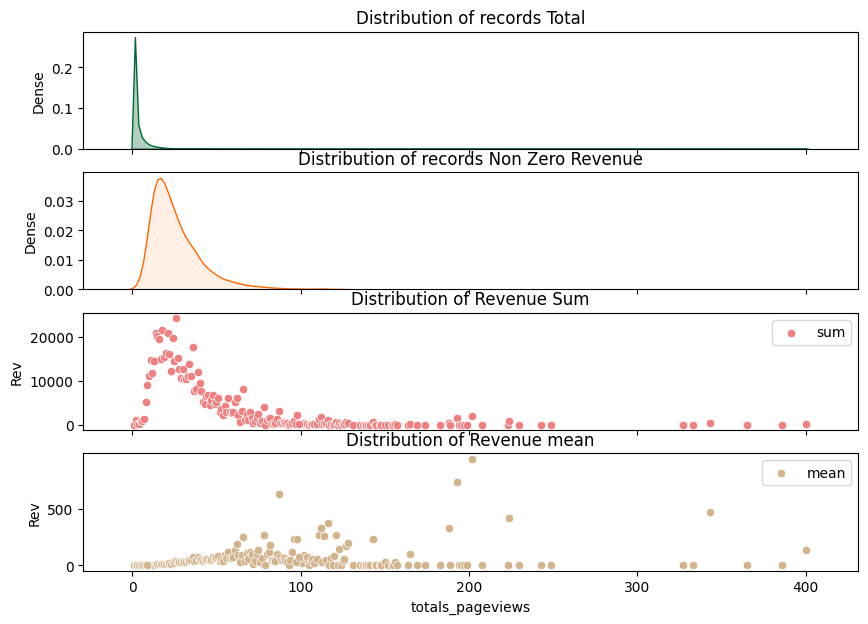

In [ ]:
cols = 'totals_pageviews'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)


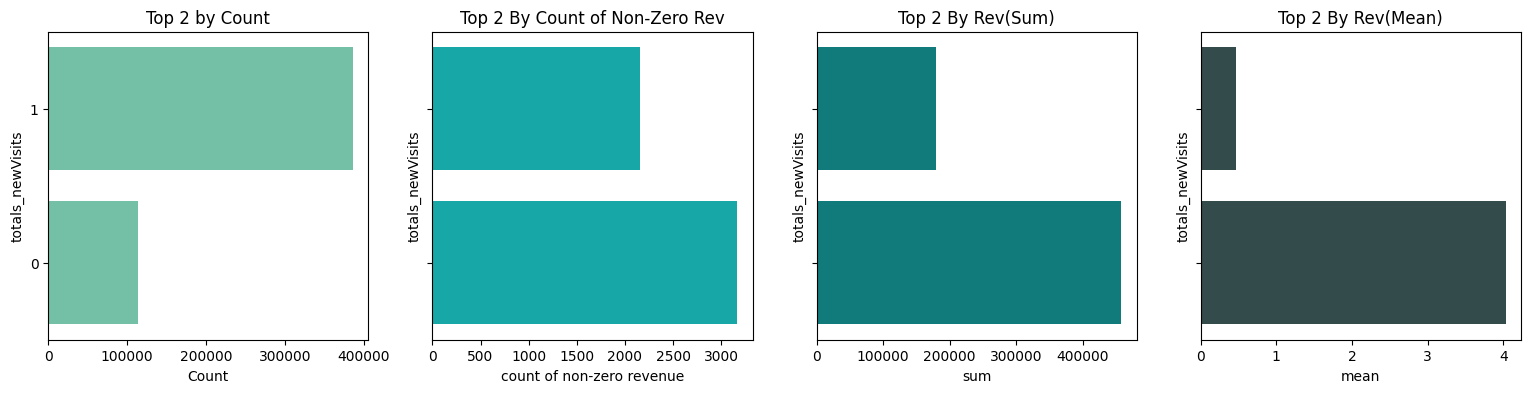

In [ ]:
data.device_isMobile.replace(True,'1',inplace=True)
data.device_isMobile.replace(False,'0',inplace=True)
data.device_isMobile.unique()
plot_list = ['totals_newVisits','device_isMobile']
bar_plot_stats(plot_list,data,y_count=2,figsize_x=19,figsize_y=4)

### trafficSource EDA

- 유입된 기여 채널을 기록하는 피처.
- 유입 채널별 성향이 상이한 경향이 있어, 유의미한 피처를 선택할 수 있다

In [ ]:
plot_list = ['trafficSource_adContent']
bar_plot_stats(plot_list,data,y_count=2,figsize_x=19,figsize_y=4)

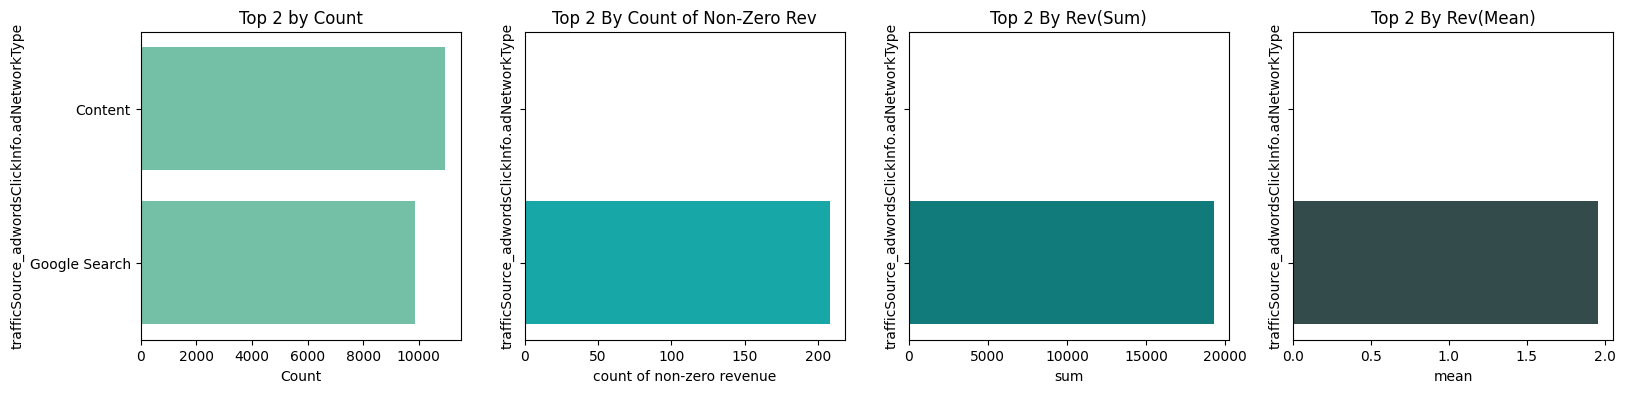

In [ ]:
plot_list = ['trafficSource_adwordsClickInfo.adNetworkType']
bar_plot_stats(plot_list,data,y_count=2,figsize_x=19,figsize_y=4)

#### trafficSource_무의미한 피처
- 개인정보 보호 목적으로 cencored 되거나 broken 된 데이터

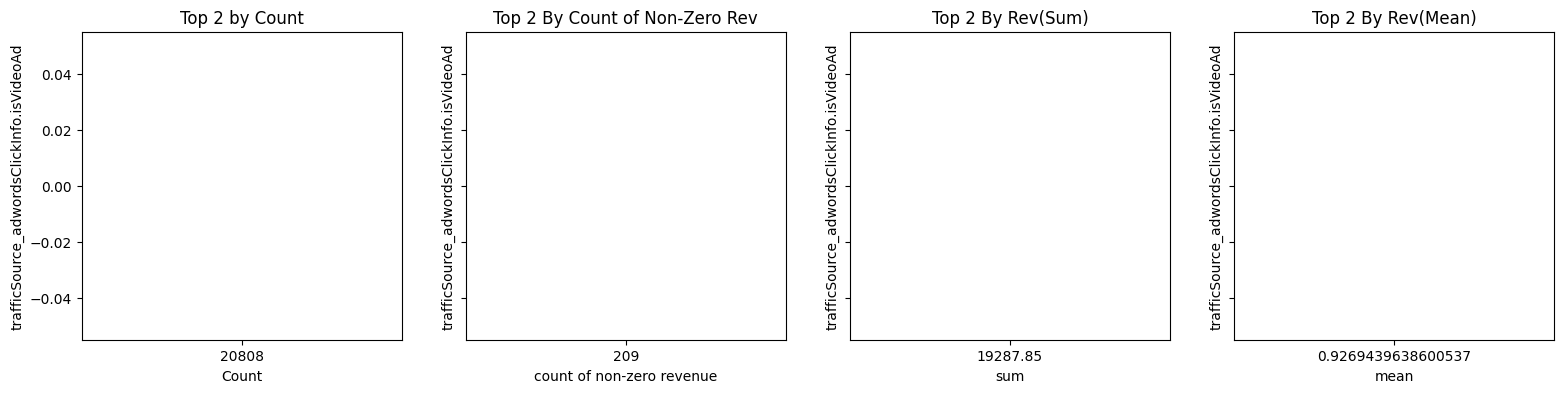

In [ ]:
plot_list = ['trafficSource_adwordsClickInfo.isVideoAd']
bar_plot_stats(plot_list,data,y_count=2,figsize_x=19,figsize_y=4)



In [ ]:
plot_list = ['trafficSource_adwordsClickInfo.page']
bar_plot_stats(plot_list,data,y_count=10,figsize_x=19,figsize_y=4)


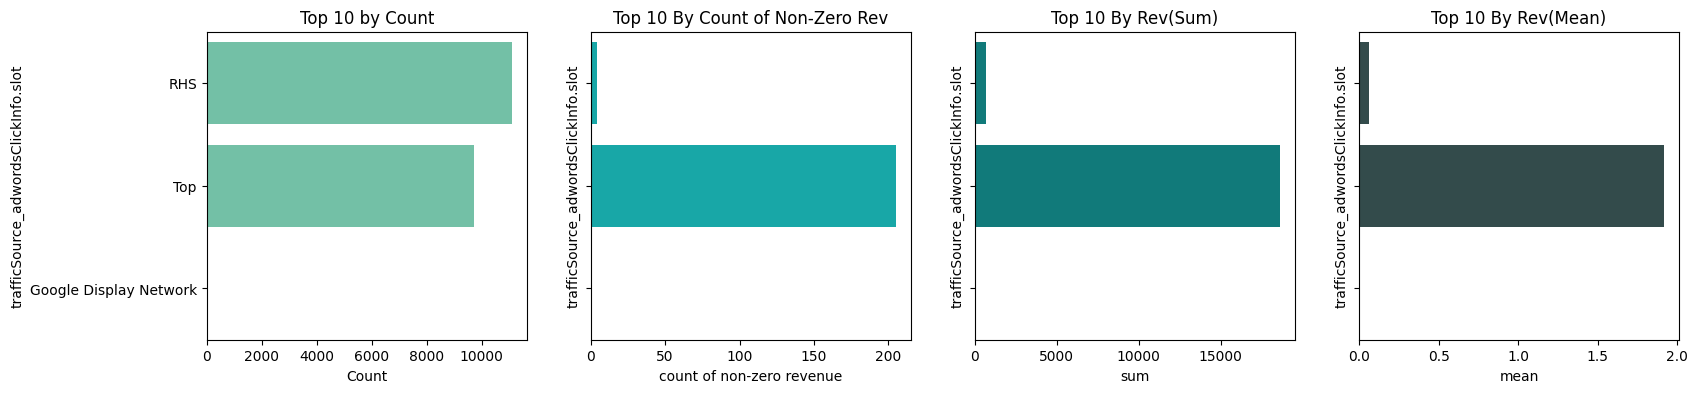

In [ ]:
plot_list = ['trafficSource_adwordsClickInfo.slot']
bar_plot_stats(plot_list,data,y_count=10,figsize_x=19,figsize_y=4)


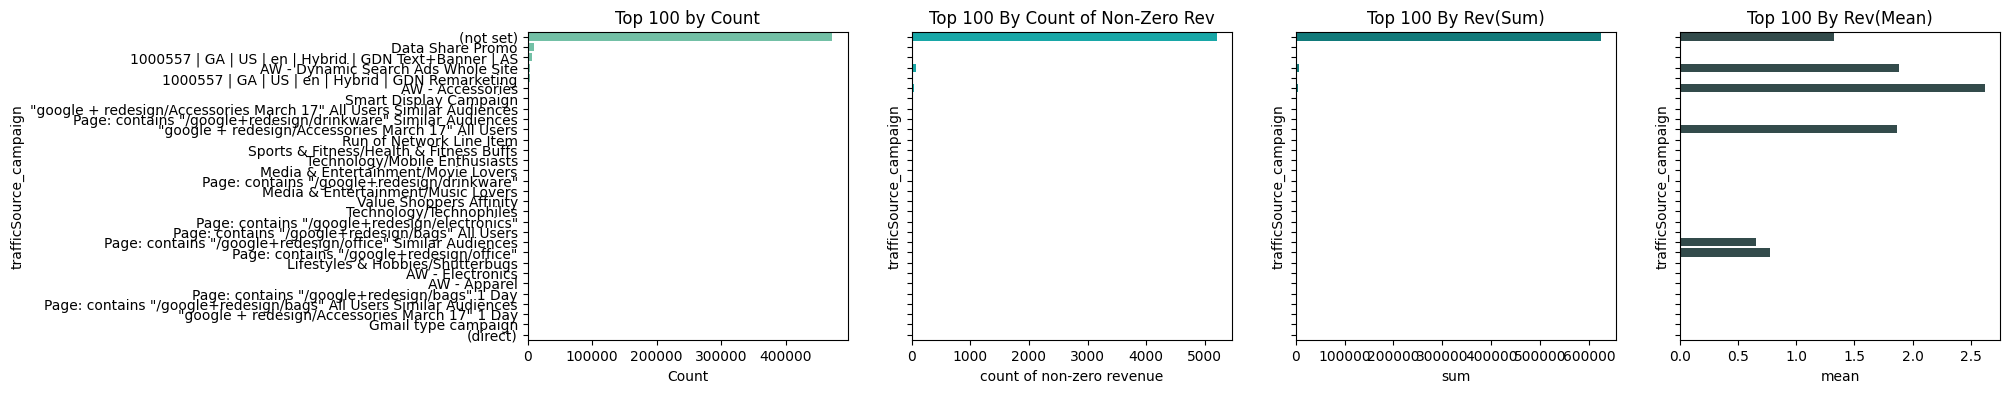

In [ ]:
plot_list = ['trafficSource_campaign',]
bar_plot_stats(plot_list,data,y_count=100,figsize_x=19,figsize_y=4)


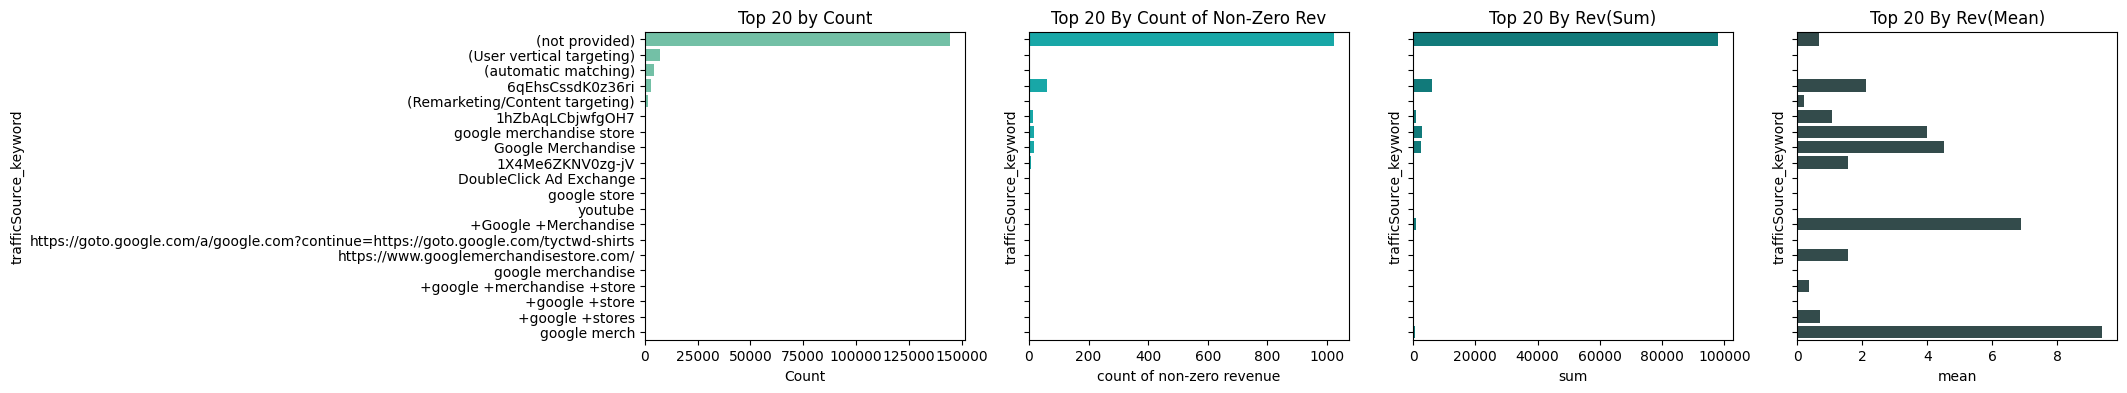

In [ ]:
plot_list = ['trafficSource_keyword']
bar_plot_stats(plot_list,data,y_count=20,figsize_x=19,figsize_y=4)

#### trafficSource_isTrueDirect
- 트래픽소스가 직접유입인지 기록하는 이진변수
- 다이렉트의 경우 재방문일 확률이 높다 판단할 수 있기에 구매 여부를 판단할 수 있다

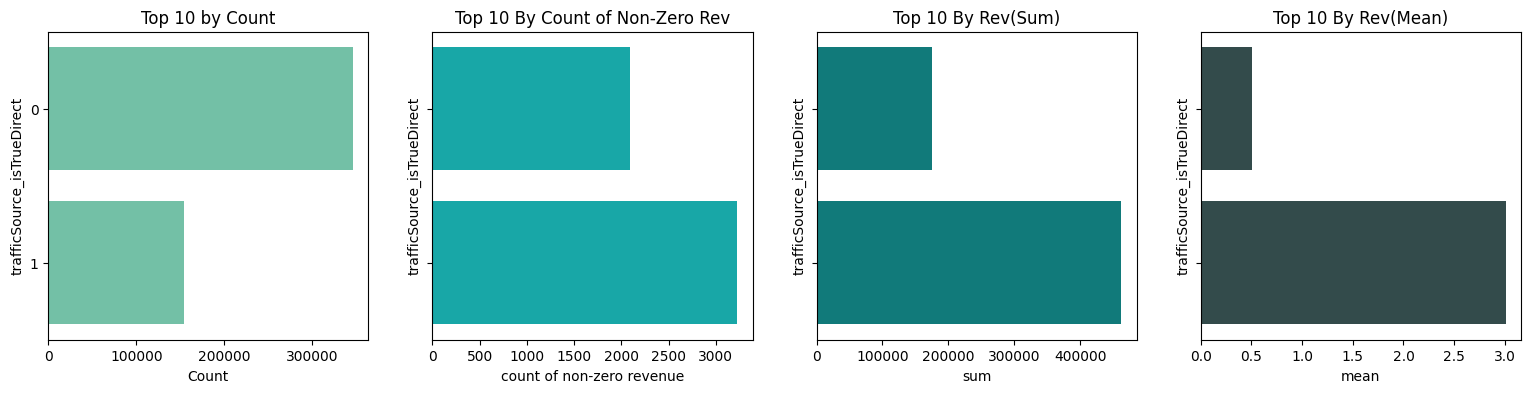

In [ ]:
data['trafficSource_isTrueDirect'].value_counts(dropna=False)
data['trafficSource_isTrueDirect'].fillna(False,inplace=True)
data['trafficSource_isTrueDirect'].replace(0,'0',inplace=True)
data['trafficSource_isTrueDirect'].replace(1,'1',inplace=True)

plot_list = ['trafficSource_isTrueDirect']
bar_plot_stats(plot_list,data,y_count=10,figsize_x=19,figsize_y=4)


#### Source/Medium
- 유입된 소스/미디엄/링크의 퍼널을 기록한 피처

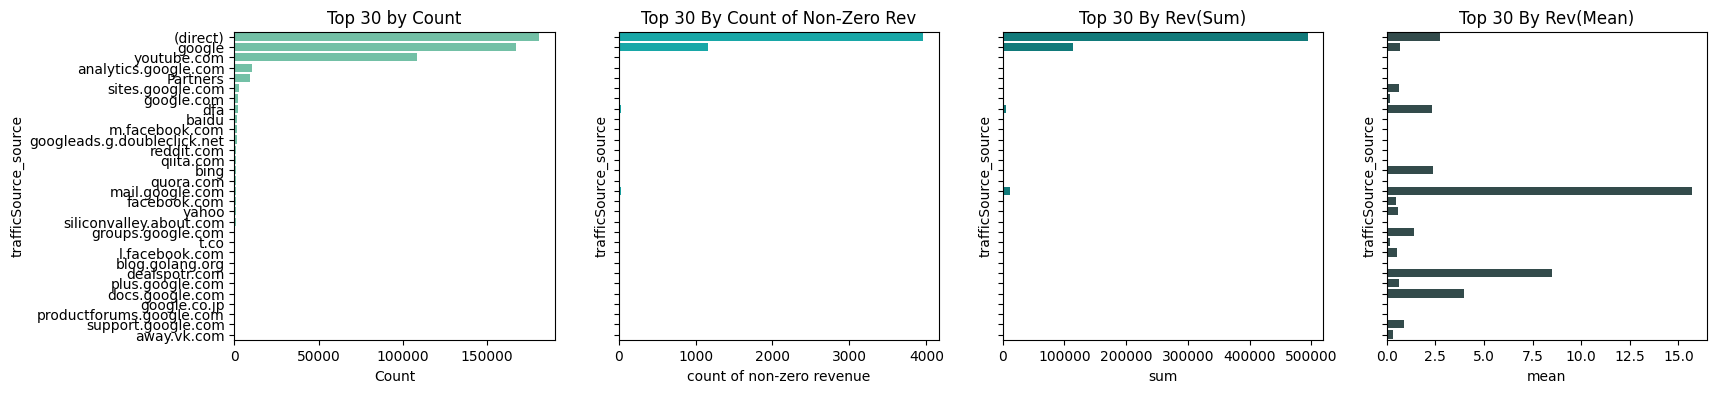

In [ ]:
plot_list = ['trafficSource_source']
bar_plot_stats(plot_list,data,y_count=30,figsize_x=19,figsize_y=4)

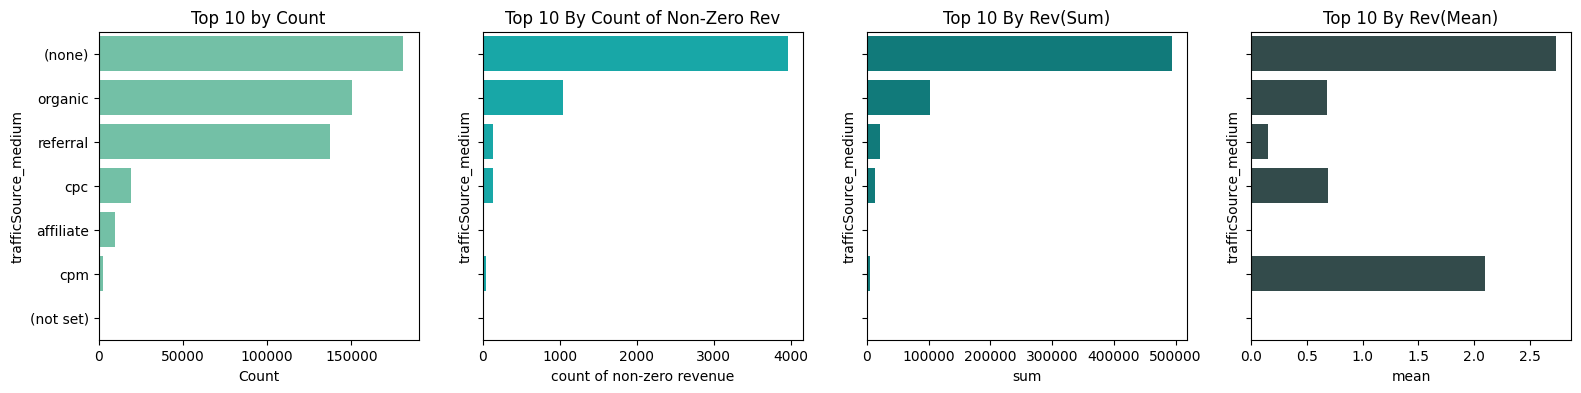

In [ ]:
plot_list = ['trafficSource_medium']
bar_plot_stats(plot_list,data,y_count=10,figsize_x=19,figsize_y=4)

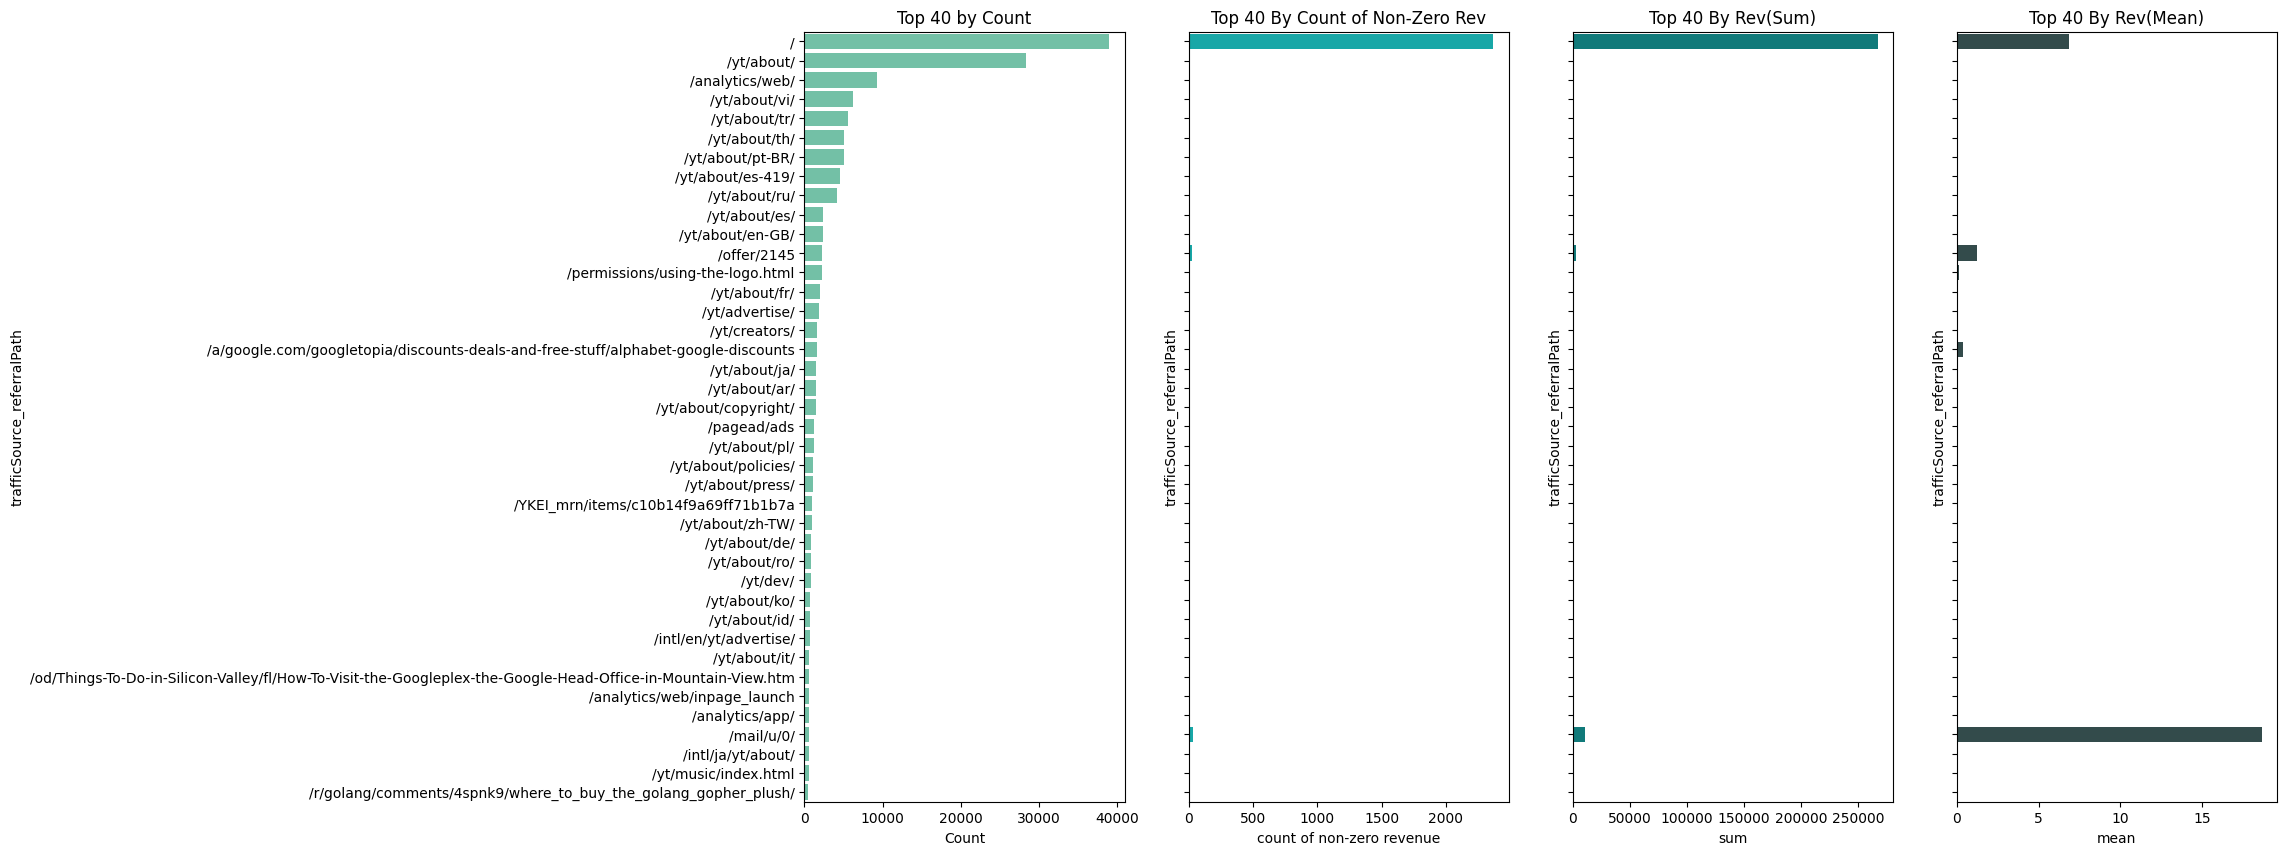

In [ ]:
plot_list = ['trafficSource_referralPath']
bar_plot_stats(plot_list,data,y_count=40,figsize_x=19,figsize_y=10)

### visit EDA

#### visitNumber
세션의 방문 횟수. 
- 방문의 길이가 구매의 수와 정비례하지 않음을 확인할 수 있다.
- 대부분의 구매는 짧은 방문 수 내로 결정된다

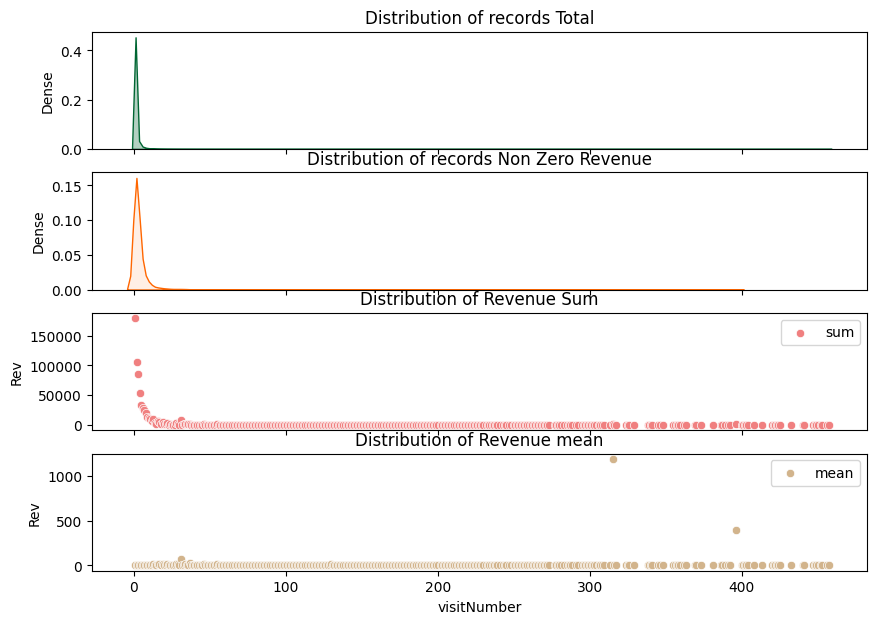

In [ ]:
cols = 'visitNumber'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

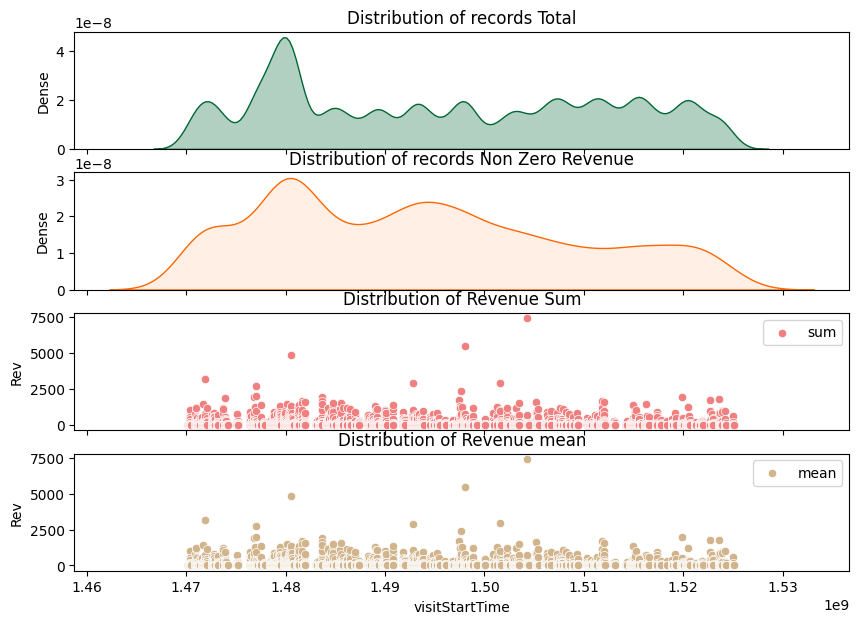

In [ ]:
cols = 'visitStartTime'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### days 기반 피쳐 생성 및 EDA
날짜별 피쳐를 파싱하여 효용성을 판단한다

In [ ]:
def get_date(data):
  data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
  data['year'] = data['date'].dt.year
  data['month'] = data['date'].dt.month
  data['week'] = data['date'].dt.week
  data['weekday'] = data['date'].dt.weekday

  data['date'] = data['date'].apply(lambda x: dt.date(x.year, x.month, x.day))

cols = 'month'
# kde_scatter(cols, data, figsize_x=10, figsize_y=7)


#### week
- ISOweek 데이터.
- 구매에 어느정도의 계절성이 있음을 확인한다.

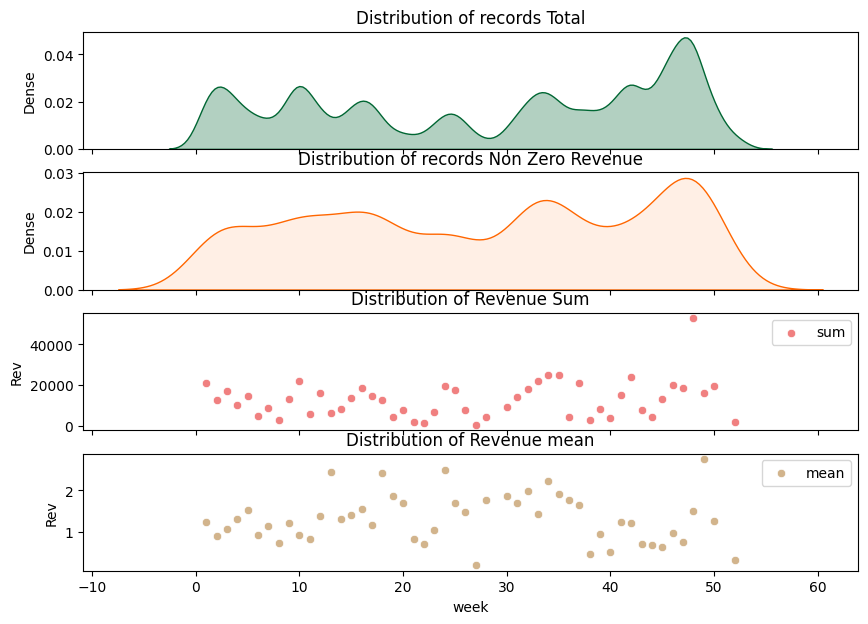

In [ ]:
cols = 'week'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### weekday
- 방문 요일에서 구매율이 떨어지는 5,6일을 확인할 수 있다.

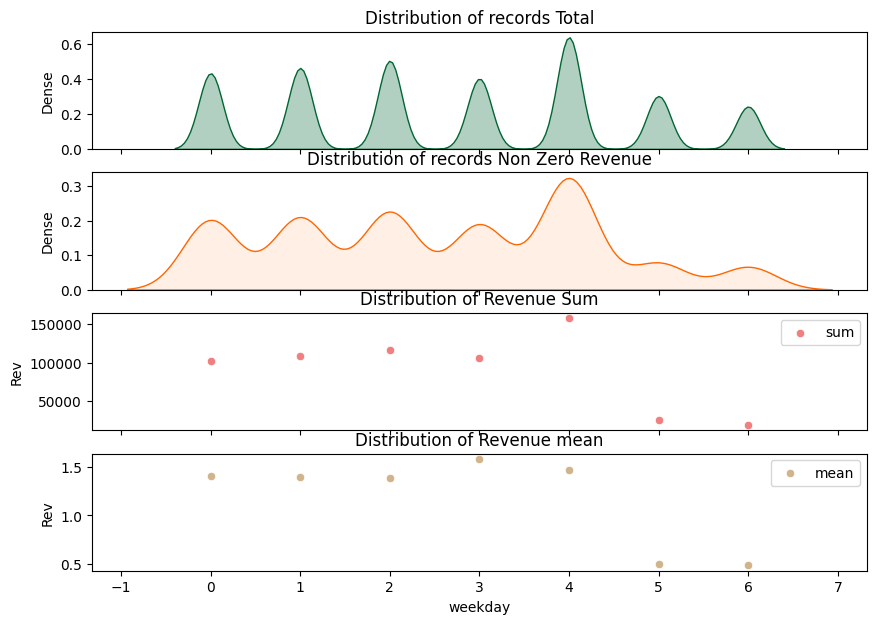

In [ ]:
cols = 'weekday'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)

#### hour
- 시간에 따른 행동 분포.
- 20시 전후로 구매자가 많이 분포한 것을 확인할 수 있다.

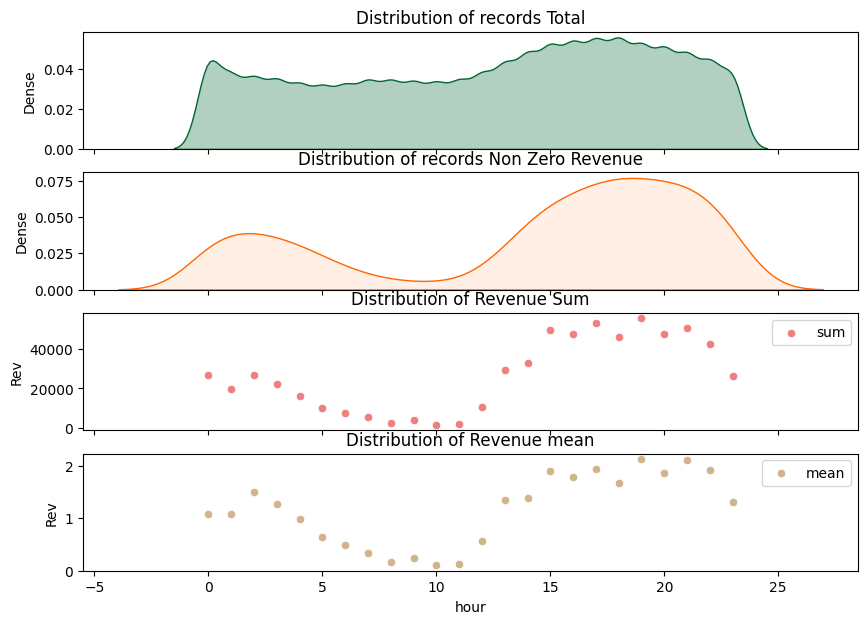

In [ ]:
data['visitStartTime'].value_counts(dropna=False)
data['visitStartTime'].unique()
# data['visitStartTime'] = pd.to_datetime(data['visitStartTime'], unit='s')
data['hour'] = data['visitStartTime'].dt.hour

cols = 'hour'
kde_scatter(cols, data, figsize_x=10,figsize_y=7)